_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*Agnese Adorante, Hwajin Shin, Lucia Gonzalez Anton* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

In [136]:
# from google.colab import drive

# drive.mount("/content/drive", force_remount=True)

# Neural Data Science Project 02

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

In [ ]:
# import packages here

import os
import numpy as np
import pandas as pd

# import seaborn as sns
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib.cm as cm
import random
from scipy.signal import find_peaks
from scipy.stats import zscore

# from oasis.functions import deconvolve
import urllib.request

url = "https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py"
urllib.request.urlretrieve(url, "oopsi.py")
import oopsi
from tqdm import tqdm
from sklearn.preprocessing import minmax_scale

from rfest import splineLG, splineLNP, splineLNLN
from rfest import ALD, ASD, GLM, LNLN, LNP
from rfest.utils import build_design_matrix

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-07-17 16:33:36Hora de ver. Europa Occidental

Python implementation: CPython
Python version       : 3.9.23
IPython version      : 8.18.1

sklearn: 1.6.1

scipy     : 1.10.1
sklearn   : 1.6.1
rfest     : 2.1.2
pandas    : 1.5.3
matplotlib: 3.9.4
tqdm      : 4.67.1
numpy     : 1.23.5
seaborn   : 0.13.2

Watermark: 2.5.0



## Context

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.


The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the stimulus frames
- the ROI masks for each cell
- a maximum activity projection of the recorded area
- running speed
- table of stimulus epochs

You will only work with a locally sparse noise stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [138]:
# load data
def load_data(path="."):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_rf.npz", allow_pickle=True)
    data = dict(data)
    array2df(data, "stim_table", ["frame", "start", "end"])
    array2df(data, "stim_epoch_table", ["start", "end", "stimulus"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


path = os.getcwd()
data = load_data(path)

print("Overview of the data")
print_info(data)

Overview of the data
[t] - <class 'numpy.ndarray'>, - (105968,)
[dff] - <class 'numpy.ndarray'>, - (189, 105968)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (8880, 3)
[stim] - <class 'numpy.ndarray'>, - (9000, 16, 28)
[roi_masks] - <class 'numpy.ndarray'>, - (189, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 105968)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



## Question

**Is there spatial structure on the location of the receptive fields?**

Implement all steps of the processing pipeline that are necessary to answer them. Think of:
1. Pre-processing
2. Spike inference
3. Tuning function fitting
4. Statistical testing.

It is sufficient to assess spatial structure visually. Additional insights and analyses will be positively factored into the overall grade.

# Utils

In [139]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors


def plot_trace_with_stimulus(
    trace,
    time,
    stim_epochs,
    start_time,
    duration,
    event_trace=None,
    fs=30,
    colormap="tab10",
    behavior=False,
):
    """
    Plots a single calcium trace with vertical background shading for each stimulus type.

    Parameters:
        trace (np.ndarray): dF/F trace of one neuron
        time (np.ndarray): time vector
        stim_epochs (pd.DataFrame): with columns ['stimulus', 'start', 'end']
        start_time (float): time to start plotting (in seconds)
        duration (float): duration to plot (in seconds)
        event_trace (np.ndarray): optional, e.g. deconvolved spikes
        fs (int): sampling rate
        colormap (str): name of matplotlib colormap
    """

    # Set time window
    start_frame = int(start_time * fs)
    end_frame = int((start_time + duration) * fs)
    time_window = time[start_frame:end_frame]
    trace_window = trace[start_frame:end_frame]
    if event_trace is not None:
        event_window = event_trace[start_frame:end_frame]

    # Create stimulus colormap
    stim_types = sorted(stim_epochs["stimulus"].unique())
    colors = cm.get_cmap(colormap, len(stim_types))
    stim_color_map = {stim: colors(i) for i, stim in enumerate(stim_types)}

    # Plot
    plt.figure(figsize=(15, 4))

    # Background shading
    for _, row in stim_epochs.iterrows():
        stim_start, stim_end = row["start"], row["end"]
        stim_label = row["stimulus"]
        if (stim_end / fs) < start_time or (stim_start / fs) > (start_time + duration):
            continue  # outside window

        # Clamp shading to plotting window
        plot_start = max(stim_start / fs, start_time)
        plot_end = min(stim_end / fs, start_time + duration)

        plt.axvspan(plot_start, plot_end, color=stim_color_map[stim_label], alpha=0.2)

    # Plot traces
    plt.plot(
        time_window,
        trace_window / trace_window.max(),
        label="dff trace",
        color="steelblue",
    )
    if event_trace is not None:
        plt.plot(time_window, event_window, label="events trace", color="orange")

    if behavior is True:
        plt.plot(
            time_window,
            running_speed[0, start_frame:end_frame]
            / running_speed[0, start_frame:end_frame].max(),
            label="running speed",
            color="green",
        )
    # Legend for stimulus types
    legend_patches = [
        mpatches.Patch(color=stim_color_map[stim], label=stim) for stim in stim_types
    ]
    event_patchs = [plt.Line2D([], [], color="steelblue", label="dff trace")]
    if event_trace is not None:
        event_patchs.append(plt.Line2D([], [], color="orange", label="events trace"))
    if behavior is True:
        event_patchs.append(plt.Line2D([], [], color="green", label="running speed"))
    plt.legend(handles=legend_patches + event_patchs)

    plt.xlabel("Time (s)")
    plt.ylabel("Normalized response magnitude")
    plt.title(f"Calcium Trace with Stimulus Background")
    plt.tight_layout()
    plt.show()

In [140]:
def plot_calcium_traces(indices, start_time, duration, fs=30, offset=3):
    """
    Plot calcium traces for selected neuron indices within a time window.

    Parameters:
        indices (list): List of neuron indices to plot
        start_time (float): Start time in seconds
        duration (float): Duration in seconds
        fs (int): Sampling rate (frames per second)
        offset (float): Vertical offset between traces
        time (np.ndarray): Time vector
        traces (np.ndarray): Calcium trace array (neurons x time)
    """
    time = data["t"]
    traces = data["dff"]

    # Convert time window to frame indices
    start_frame = int(start_time * fs)
    end_frame = int((start_time + duration) * fs)

    # Extract time and trace segments
    time_window = time[start_frame:end_frame]
    trace_window = traces[:, start_frame:end_frame]

    # Plot
    plt.figure(figsize=(12, 6))
    for i, neuron_idx in enumerate(indices):
        trace = trace_window[neuron_idx]
        trace_norm = trace / trace.max()  # normalize
        plt.plot(time_window, trace_norm + i * offset, color="black")

    plt.title(f"Normalized Calcium Traces")
    plt.xlabel("Time (s)")
    plt.yticks(np.arange(len(indices)) * offset, indices)
    plt.ylabel("Neuron ID")
    plt.tight_layout()
    plt.show()

# Exploratory Data Analysis

In [141]:
# Clacium trace
traces = data["dff"]  # shape: (n_cells, n_frames)

# Stimuli
stim_epochs = data["stim_epoch_table"]
stim_epochs.columns = ["stimulus", "start", "end"]
stim_metadata = data["stim_table"]
stims = data["stim"]

# Roi masks and projections
roi_masks = data["roi_masks"]
max_projection = data["max_projection"]

# Behavior
running_speed = data["running_speed"]

# time
time = data["t"]

In [142]:
print("Traces Info")
print(f"Number of cells: {traces.shape[0]}")
print(f"Number of frames: {traces.shape[1]}")
print("---------------------------------------------------")
print("Stimulus Info")
print(f"Number of stimulus epochs: {len(stim_epochs)}")
print(f"Stimuli types: {set(stim_epochs['stimulus'])}")
print(f"Number of presented stimuli: {stim_metadata.shape[0]}")
print(f"Stimulus shape: {stims.shape[1], stims.shape[2]}")
print("---------------------------------------------------")
print("Recording Frequency")
dt = np.median(np.diff(time))  # sampling interval in seconds
fs = 1 / dt  # sampling frequency in Hz
print(f"Time resolution: {np.round(fs)} Hz")
print("---------------------------------------------------")
print("ROI Masks Info")
print(f"Max projection shape: {max_projection.shape}")
print(f"Number of ROIs: {roi_masks.shape[0]}")

Traces Info
Number of cells: 189
Number of frames: 105968
---------------------------------------------------
Stimulus Info
Number of stimulus epochs: 7
Stimuli types: {'natural_movie_one', 'locally_sparse_noise', 'natural_movie_two', 'spontaneous'}
Number of presented stimuli: 8880
Stimulus shape: (16, 28)
---------------------------------------------------
Recording Frequency
Time resolution: 30.0 Hz
---------------------------------------------------
ROI Masks Info
Max projection shape: (512, 512)
Number of ROIs: 189


## Calcium Trace

Text(0, 0.5, 'Neurons')

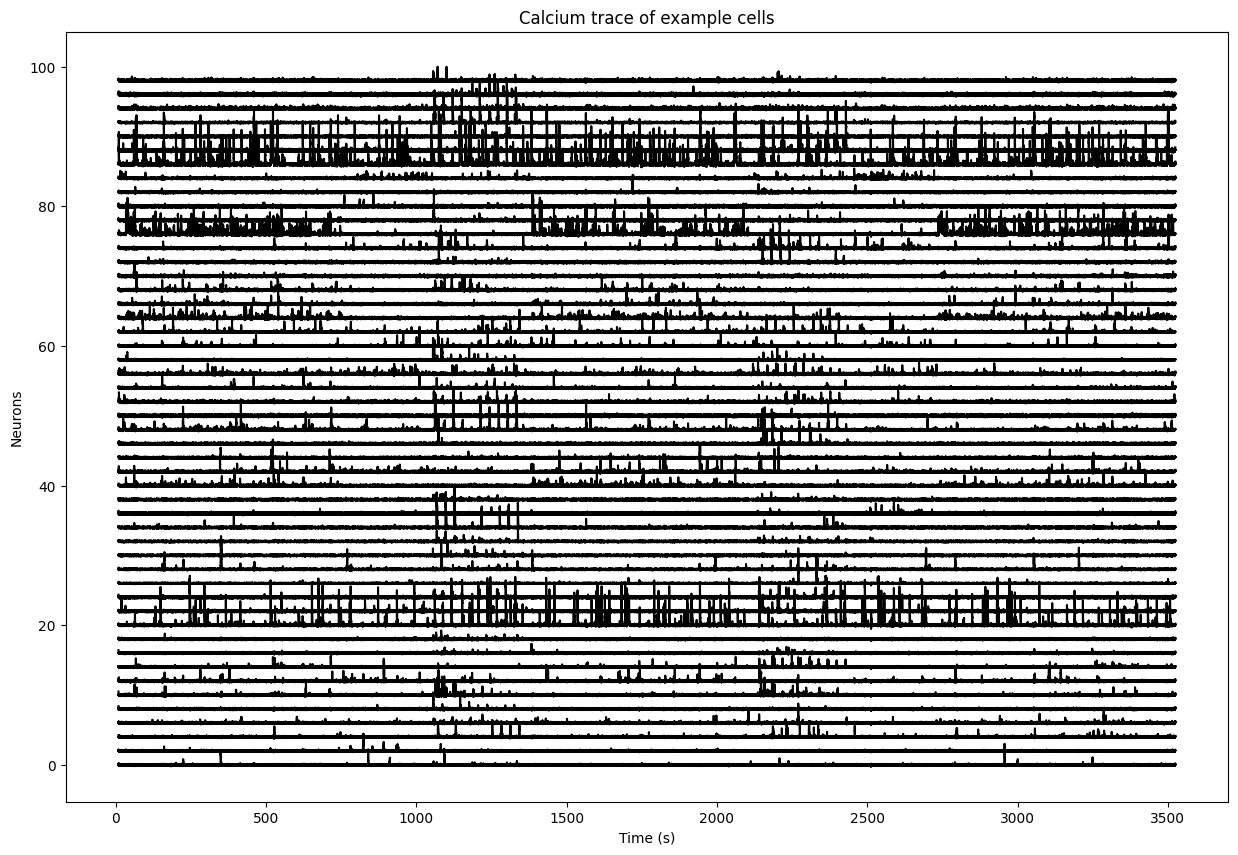

In [143]:
fig = plt.figure(figsize=(15, 10))
for i in range(50):
    plt.plot(time, traces[i, :] + (i * 2), color="black")
plt.title("Calcium trace of example cells")
plt.xlabel("Time (s)")
plt.ylabel("Neurons")

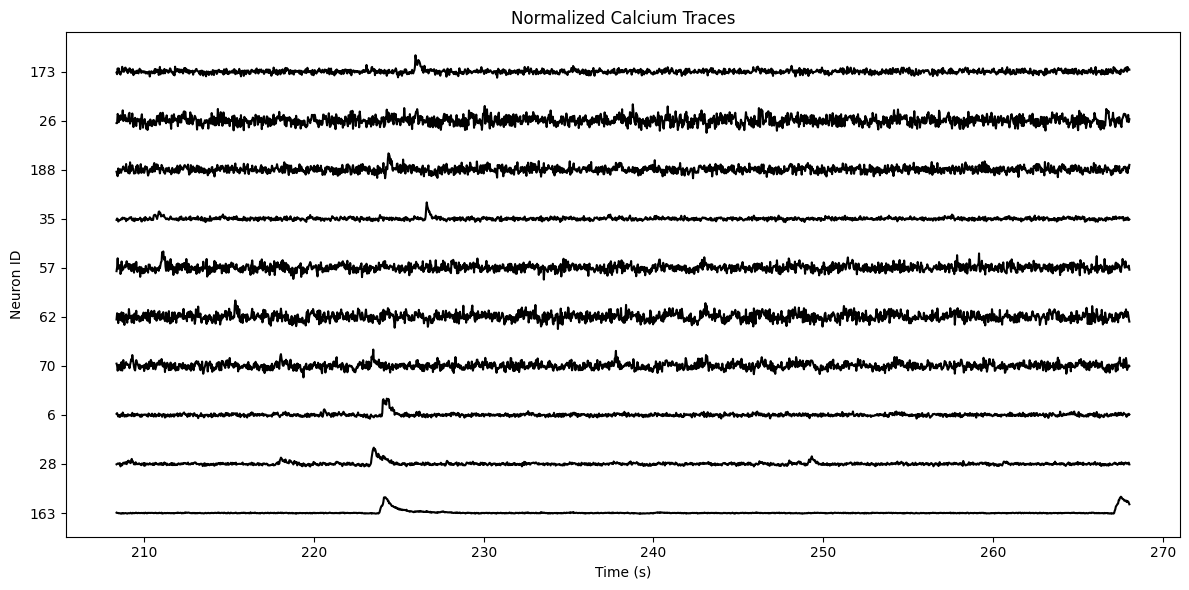

In [144]:
random.seed(42)
indices = random.sample(range(traces.shape[0]), 10)

plot_calcium_traces(indices, start_time=200, duration=60)

C:\Users\34600\AppData\Local\Temp\ipykernel_2068\3016076656.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap(colormap, len(stim_types))


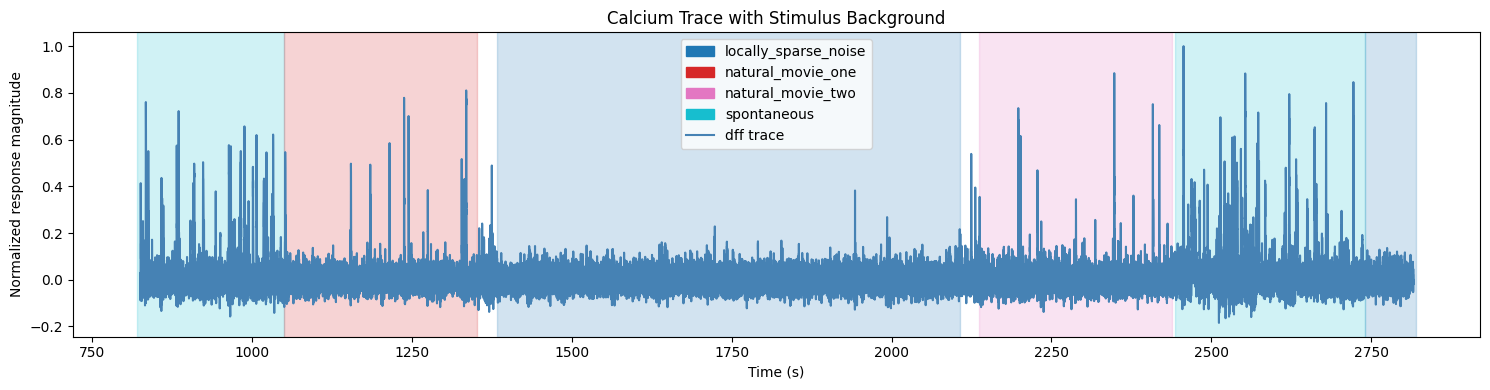

In [145]:
# Choose neuron index and time window
neuron_idx = 42
start_time = 820
duration = 2000

# Use your data
trace = traces[neuron_idx]

# Call function (without events)
plot_trace_with_stimulus(trace, time, stim_epochs, start_time, duration)

C:\Users\34600\AppData\Local\Temp\ipykernel_2068\3016076656.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap(colormap, len(stim_types))


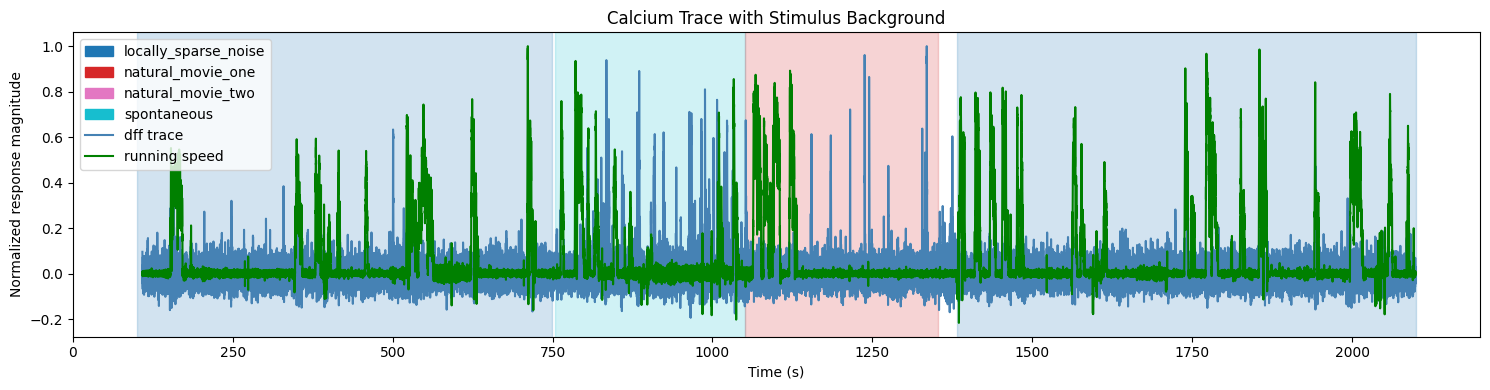

In [146]:
neuron_idx = 42
start_time = 100
duration = 2000

# Use your data
trace = traces[neuron_idx]

# Call function (without events)
plot_trace_with_stimulus(trace, time, stim_epochs, start_time, duration, behavior=True)

C:\Users\34600\AppData\Local\Temp\ipykernel_2068\3016076656.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap(colormap, len(stim_types))


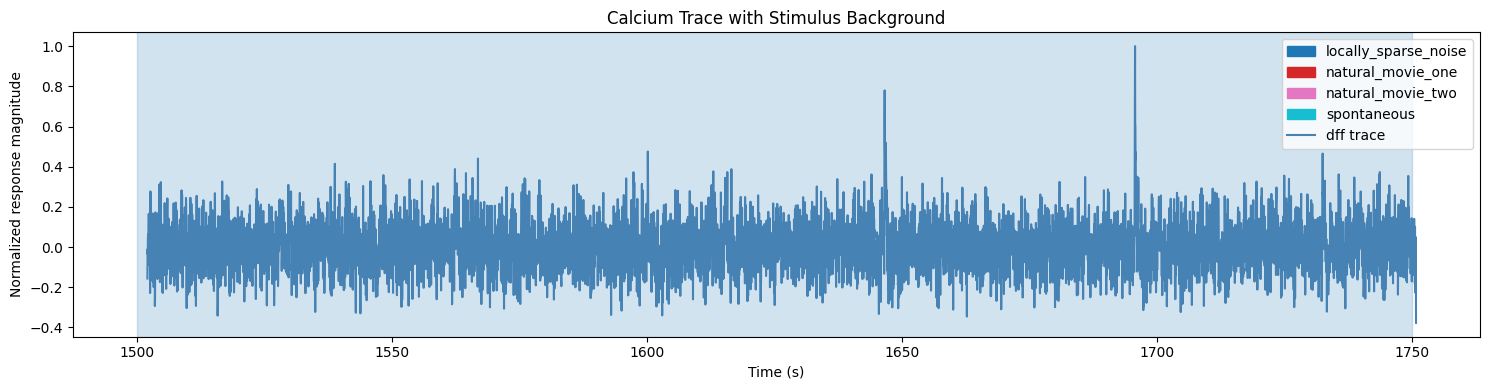

In [147]:
neuron_idx = 11
start_time = 1500
duration = 250

# Use your data
trace = traces[neuron_idx]

# Call function (without events)
plot_trace_with_stimulus(trace, time, stim_epochs, start_time, duration)

## Stimulus

**Locally Sparse Noise**

The locally sparse noise stimulus consists of black and white spots flashed on the monitor. For each frame of the stimulus a small number of pixels were white and a small number were black, while the rest were mean luminance gray. The white and black spots were distributed such that no two spots were within 5 pixels of each other. Each time a given pixel was occupied by a black (or white) spot, there was a different array of other pixels occupied by either black or white spots. As a result, when all of the frames when that pixel was occupied by the black spot were averaged together, there was no significant structure surrounding the specified pixel. Further, the stimulus was well balanced with regards to the contrast of the pixels, such that while there was a slightly higher probability of a pixel being occupied just outside of the 5-pixel exclusion zone, the probability was equal for pixels of both contrast. Each pixel was occupied by either a white or black spot a variable number of times. Typically, each frame we presented for 0.25 seconds and followed immediately by the next trial without any intertrial interval. There are no blanksweeps.

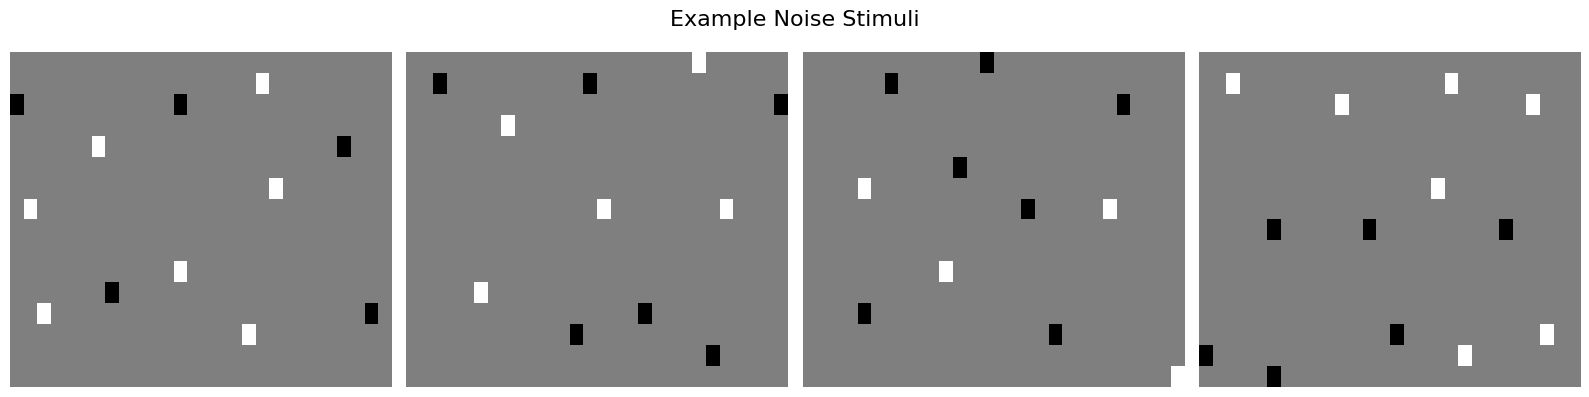

In [148]:
# Filter stim_epochs for only locally_sparse_noise
lsn_epochs = stim_epochs[stim_epochs["stimulus"] == "locally_sparse_noise"]

# Get all frames within those epochs
lsn_frame_idxs = []
for _, row in lsn_epochs.iterrows():
    start, end = row["start"], row["end"]
    matching_frames = stim_metadata[
        (stim_metadata["start"] >= start) & (stim_metadata["end"] <= end)
    ]
    lsn_frame_idxs.extend(matching_frames["frame"].values)

lsn_frame_idxs = np.array(lsn_frame_idxs)
n = len(lsn_frame_idxs)

# Pick 4 evenly spaced frame indices
example_indices = np.linspace(0, n - 1, 4, dtype=int)
example_frames = [stims[lsn_frame_idxs[i]] for i in example_indices]

# Plot them
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    axs[i].imshow(example_frames[i], cmap="grey", aspect="auto")
    axs[i].axis("off")

plt.suptitle("Example Noise Stimuli", fontsize=16)
plt.tight_layout()
plt.show()

In [149]:
np.unique(stims[0])

array([  0, 127, 255], dtype=uint8)

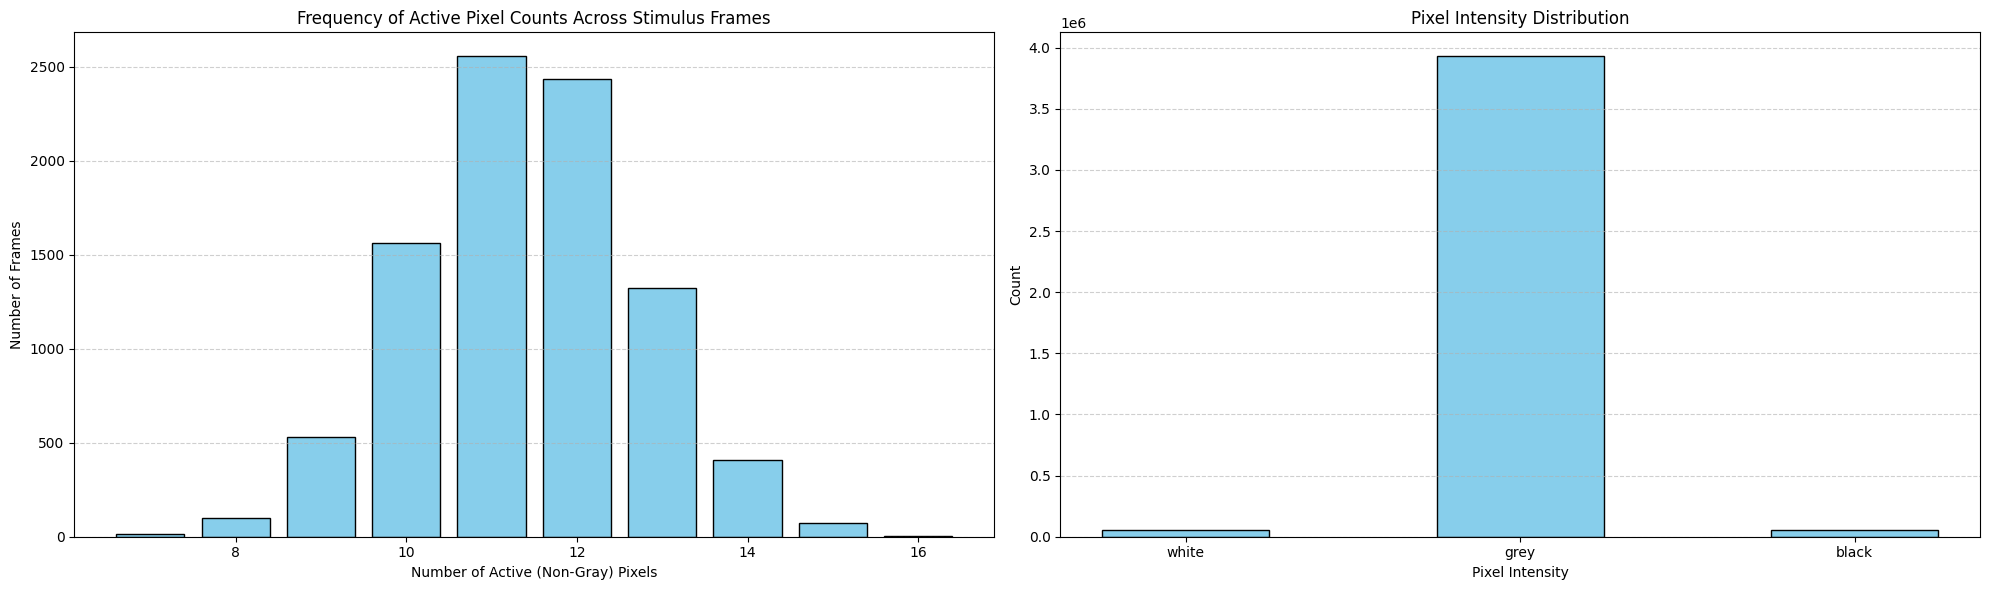

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Subplot 1: Frequency of Active Pixel Counts (Bar Plot)
gray_value = 127
non_gray_counts = np.sum(stims != gray_value, axis=(1, 2))
unique_counts, counts_frequency = np.unique(non_gray_counts, return_counts=True)

axs[0].bar(unique_counts, counts_frequency, color="skyblue", edgecolor="black")
axs[0].set_title("Frequency of Active Pixel Counts Across Stimulus Frames")
axs[0].set_xlabel("Number of Active (Non-Gray) Pixels")
axs[0].set_ylabel("Number of Frames")
axs[0].grid(axis="y", linestyle="--", alpha=0.6)

# Subplot 2: Pixel Intensity Distribution (Only 0, 127, 255)
intensity_labels = ["white", "grey", "black"]
intensity_values = [0, 127, 255]
intensity_counts = [np.sum(stims == val) for val in intensity_values]

axs[1].bar(
    [str(i) for i in intensity_labels],
    intensity_counts,
    color="skyblue",
    edgecolor="black",
    width=0.5,
)
axs[1].set_title("Pixel Intensity Distribution")
axs[1].set_xlabel("Pixel Intensity")
axs[1].set_ylabel("Count")
axs[1].grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

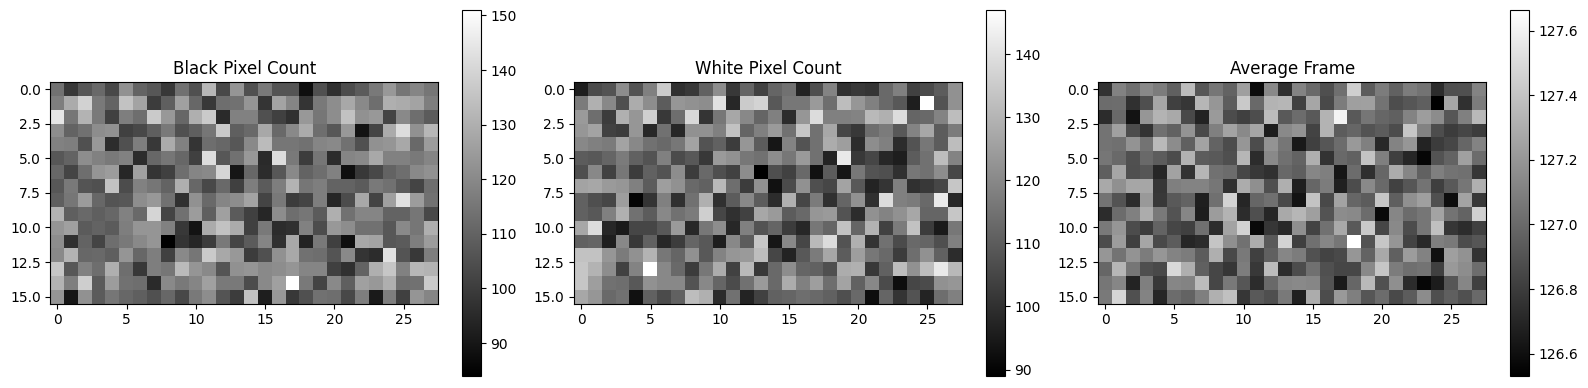

In [151]:
black_count = np.sum(stims == 0, axis=0)
white_count = np.sum(stims == 255, axis=0)
avg_frame = np.mean(stims, axis=0)

plt.figure(figsize=(16, 4))  # Adjust figure size for 1 row, 3 columns

plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st plot
plt.imshow(black_count, cmap="gray")
plt.title("Black Pixel Count")
plt.colorbar()

plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd plot
plt.imshow(white_count, cmap="gray")
plt.title("White Pixel Count")
plt.colorbar()

plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd plot
plt.imshow(avg_frame, cmap="gray")
plt.title("Average Frame")
plt.colorbar()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

## ROi and max proj

(-0.5, 511.5, 511.5, -0.5)

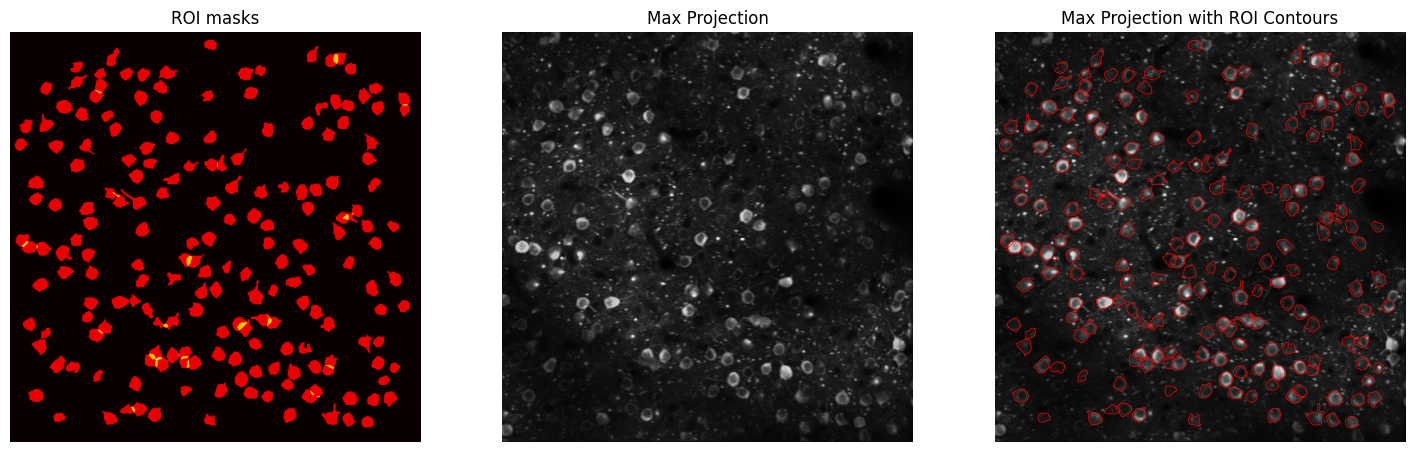

In [152]:
fig, ax = plt.subplots(1, 3, figsize=(18, 10))
# roi masks: all of the segmented masks for cell bodies in this experiment.
ax[0].imshow(roi_masks.sum(axis=0), cmap="hot")
ax[0].set_title("ROI masks")
ax[0].axis("off")
# max projection: the projection of the full motion corrected movie for all of the cells imaged during the session.
ax[1].imshow(max_projection, cmap="grey")
ax[1].set_title("Max Projection")
ax[1].axis("off")
# max projection with ROI
ax[2].imshow(max_projection, cmap="gray")
ax[2].set_title("Max Projection with ROI Contours")
for roi in roi_masks:
    ax[2].contour(roi, levels=[0.5], colors="r", linewidths=0.5)
ax[2].axis("off")

In [153]:
max_projection.shape

(512, 512)

(-0.5, 24.5, 24.5, -0.5)

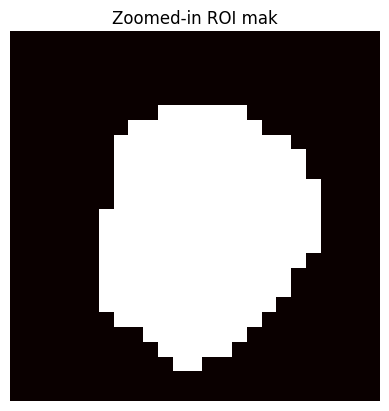

In [154]:
plt.imshow(roi_masks[0, 55:80, 100:125], cmap="hot")
plt.title("Zoomed-in ROI mak")
plt.axis("off")

# Pre-processing

In [155]:
# cutoff and fs and order can be manipulated
def lowpass_filter(trace, cutoff=0.7, fs=fs, order=3):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    filtered_trace = np.zeros_like(trace)
    b, a = signal.butter(order, norm_cutoff, btype="low", analog=False)
    neuron = signal.filtfilt(b, a, trace)
    return neuron


filtered_trace = lowpass_filter(traces)
normalized_trace = zscore(filtered_trace, axis=1)

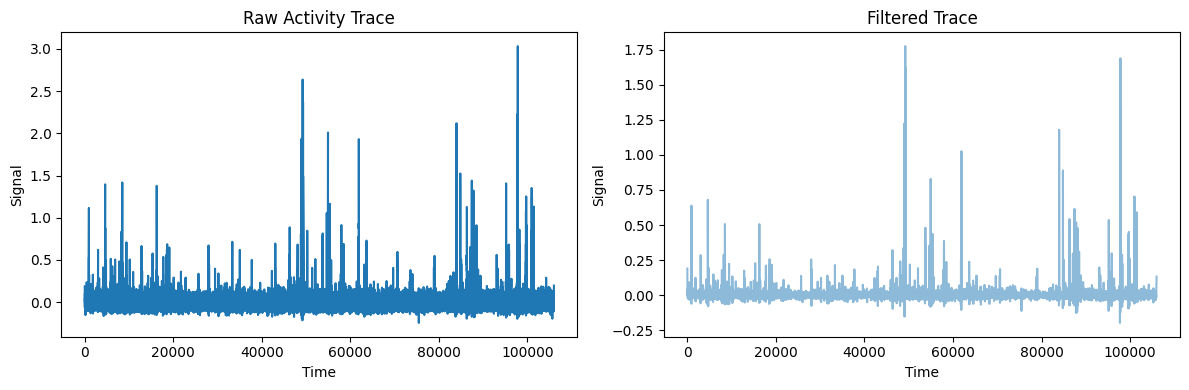

In [156]:
# Plot raw vs filtered trace
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot filtered trace
axs[0].plot(traces[100, :])
axs[0].set_title("Raw Activity Trace")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Signal")

# Plot raw activity trace
axs[1].plot(filtered_trace[100, :], alpha=0.5)
axs[1].set_title("Filtered Trace")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Signal")

# Adjust layout
plt.tight_layout()
plt.show()

# Events Extraction (Spike extraction)

To extract neural events from calcium traces, we used three different approaches to ensure reliable spike inference. 

First, we applied simple spike thresholding using the find_peaks function to detect prominent peaks in the signal, which likely correspond to firing events. 

Next, we used OOPSI, a model-based method that estimates spike probabilities by accounting for the dynamics of calcium decay, offering a more refined prediction than thresholding. 

Lastly, we applied OASIS, a fast deconvolution algorithm that infers spike timings by modeling the calcium signal as a response to discrete neural events.

## Thresholding Spike extraction

In [157]:
# Threshold for spike detection
N = 2  # Can be adjusted based on signal characteristics


def detect_spikes_single_neuron(
    trace: np.ndarray, fs: float, N: int = N, lockout: float = 0.25
):
    """
    Detect spikes in a single calcium trace using thresholding and a lockout window.

    Returns:
        spike_idxs: Indices of detected spikes
        spike_trace: 1D float array with 1s at spike times, 0s elsewhere
    """
    threshold = N
    min_distance = max(1, int(lockout * fs))
    spike_idxs, _ = find_peaks(trace, height=threshold, distance=min_distance)
    spike_trace = np.zeros_like(trace, dtype=float)
    spike_trace[spike_idxs] = 1.0  # Impulse at spike time
    return spike_trace


def run_detect_spikes_all_neurons(data, fs=fs, N=N, lockout=0.25):
    """
    Apply spike detection to all neurons and return a 2D spike matrix (float).
    """
    n_neurons, n_timepoints = data.shape
    threshold_spikes = np.zeros((n_neurons, n_timepoints), dtype=float)

    for neuron_id in range(n_neurons):
        spike_trace = detect_spikes_single_neuron(
            data[neuron_id], fs=fs, N=N, lockout=lockout
        )
        threshold_spikes[neuron_id] = spike_trace

    return threshold_spikes


# Run threshold-based spike inference (as float matrix for plotting)
threshold_spikes = run_detect_spikes_all_neurons(
    normalized_trace, fs=fs, N=N, lockout=0.25
)

In [ ]:
def plot_detected_spikes(trace, spike_idxs, fs, neuron_id="neuron_id", window=None):
    """
    Plot the calcium trace with detected spikes shown as red crosses.

    Parameters:
        trace: 1D np.array, calcium trace of one neuron
        spike_idxs: list or np.array of spike indices
        fs: sampling rate in Hz
        neuron_id: int or str, for labeling
        window: tuple (start_time, end_time) in seconds (optional)
    """
    trace = np.asarray(trace)
    spike_idxs = np.asarray(spike_idxs, dtype=int)
    t = np.arange(len(trace)) / fs

    if window:
        start_time, end_time = window
        idx_start = int(start_time * fs)
        idx_end = int(end_time * fs)
        t = t[idx_start:idx_end]
        trace = trace[idx_start:idx_end]

        # Only include spikes within the window
        spike_idxs = spike_idxs[(spike_idxs >= idx_start) & (spike_idxs < idx_end)]
        spike_idxs_windowed = spike_idxs - idx_start
    else:
        spike_idxs_windowed = spike_idxs

    # Safety check: ensure all spike indices are within range
    spike_idxs_windowed = spike_idxs_windowed[
        (spike_idxs_windowed >= 0) & (spike_idxs_windowed < len(trace))
    ]

    plt.figure(figsize=(12, 4))
    plt.plot(t, trace, label="Calcium Trace")
    plt.scatter(
        t[spike_idxs_windowed],
        trace[spike_idxs_windowed],
        color="red",
        marker="x",
        label="Detected Spikes",
        zorder=3,
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Fluorescence")
    plt.title(f"Neuron {neuron_id} - Detected Spikes")
    plt.legend()
    plt.tight_layout()
    plt.show()

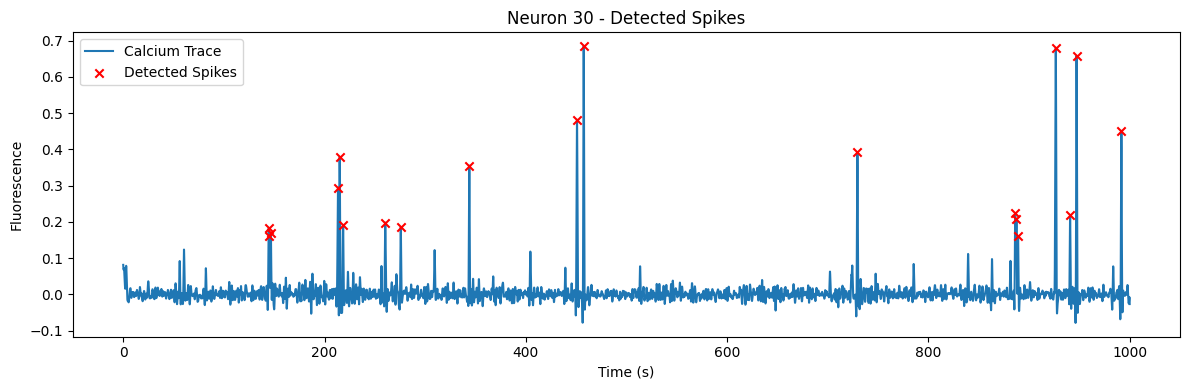

In [159]:
neuron_id = 30
trace = filtered_trace[neuron_id]  # calcium trace
spike_trace = threshold_spikes[neuron_id]  # binary spike train

# Extract spike indices where spike_trace == 1
spike_idxs = np.where(spike_trace == 1)[0]

# Plot
plot_detected_spikes(trace, spike_idxs, fs=fs, neuron_id=neuron_id, window=(0, 1000))

## Spike Extraction with OOPSIE

In [160]:
example_neuron = normalized_trace[60, :]
n, C = oopsi.fast(example_neuron, dt=1 / fs, iter_max=100, update=True)

In [161]:
oopsi_result = np.load("oopsi_results.npz")
oopsi_spikes = oopsi_result["n_traces"]

## Spike Extraction with OASIS

In [162]:
example_neuron = normalized_trace[60, :]
# c, s, b, g, lam = deconvolve(example_neuron, penalty=1)

In [ ]:
# # Assuming normalized_trace is a NumPy array of shape (n_neurons, n_frames)
# n_neurons, n_frames = normalized_trace.shape
# oasis_spikes = np.zeros((n_neurons, n_frames))

# # Loop with progress bar
# for i in tqdm(range(n_neurons), desc="Deconvolving neurons"):
#     _, s, _, _, _ = deconvolve(normalized_trace[i, :], penalty=1)
#     oasis_spikes[i, :] = s

In [164]:
# Save the result to a .npz file
# np.savez("OASIS_spikes.npz", spike_likelihoods=oasis_spikes)

In [165]:
oasis_result = np.load("OASIS_spikes.npz")
oasis_spikes = oasis_result["spike_likelihoods"]

## Method comparison

OOPSI and OASIS are model-based spike inference methods that estimate neural activity by modeling calcium dynamics, producing continuous-valued outputs that reflect spike probabilities or rates. This allows them to capture subtle changes and reduce noise-related artifacts. In contrast, thresholding is a simpler, rule-based method that detects spikes as binary events based on peak height, without accounting for calcium kinetics or noise structure.

Since these methods differ in complexity and output type, we will compare their results using correlation-based metrics to evaluate consistency and decide which approach is most suitable for our dataset.

### 1. Visualization of spikes

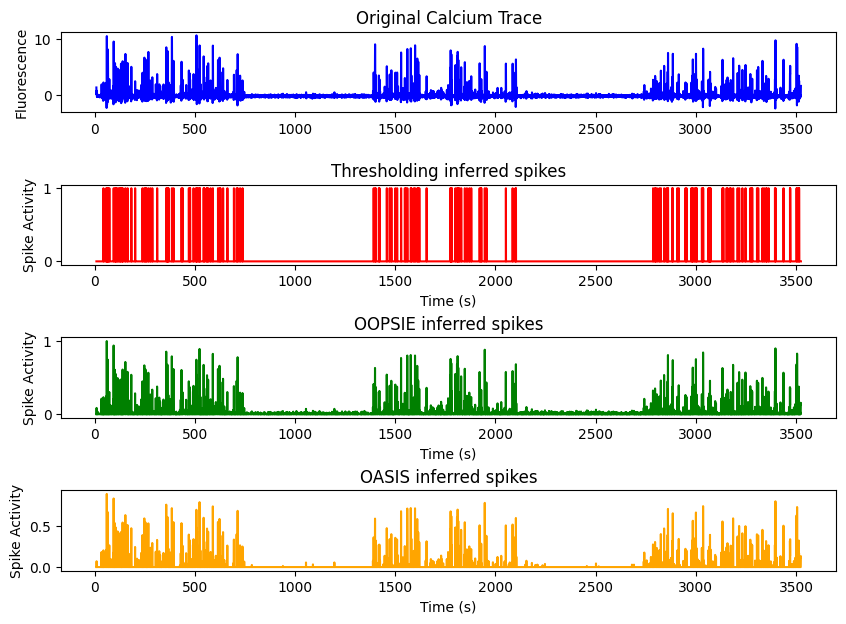

In [166]:
fig, axs = plt.subplots(
    4, 1, figsize=(10, 7), height_ratios=[1, 1, 1, 1], gridspec_kw=dict(hspace=0.9)
)

# Plot 1: Original Calcium Trace
axs[0].plot(time, example_neuron, label="Original Calcium", color="blue")
axs[0].set_ylabel("Fluorescence")
axs[0].set_title("Original Calcium Trace")

# Plot 3: Inferred Spikes
axs[1].plot(time, threshold_spikes[60], label="Inferred Spikes", color="red")
axs[1].set_ylabel("Spike Activity")
axs[1].set_xlabel("Time (s)")
axs[1].set_title("Thresholding inferred spikes")

# Plot 3: Inferred Spikes
axs[2].plot(time, oopsi_spikes[60, :], label="Inferred Spikes", color="green")
axs[2].set_ylabel("Spike Activity")
axs[2].set_xlabel("Time (s)")
axs[2].set_title("OOPSIE inferred spikes")

# Plot 3: Inferred Spikes
axs[3].plot(time, oasis_spikes[60, :], label="Inferred Spikes", color="ORANGE")
axs[3].set_ylabel("Spike Activity")
axs[3].set_xlabel("Time (s)")
axs[3].set_title("OASIS inferred spikes")

plt.show()

### 2. Spike normalization

It can be seen that the OOPSI and OASIS inferred spikes do not reach values. In order to compare both methods we will first normalize it.

In [167]:
def plot_population_firing_rate(
    spike_traces, bin_size=30, sampling_rate=30, threshold=0.5, figsize=(8, 4)
):
    """
    Plots average population firing rate over time.

    Parameters:
    - spike_traces: array of shape (n_neurons, n_frames)
    - bin_size: number of frames per bin (e.g. 30 = 1 sec @ 30 Hz)
    - sampling_rate: imaging rate
    - threshold: spike detection threshold
    """
    n_neurons, n_frames = spike_traces.shape
    spike_binary = spike_traces > threshold
    n_bins = n_frames // bin_size
    pop_rate = []

    for i in range(n_bins):
        bin_slice = slice(i * bin_size, (i + 1) * bin_size)
        rate = spike_binary[:, bin_slice].sum() / (
            n_neurons * (bin_size / sampling_rate)
        )  # spikes/s/neuron
        pop_rate.append(rate)

    time_bins = np.arange(n_bins) * (bin_size / sampling_rate)

    plt.figure(figsize=figsize)
    plt.plot(time_bins, pop_rate, color="dodgerblue")
    plt.xlabel("Time (s)")
    plt.ylabel("Avg Firing Rate (Hz)")
    plt.title("Population Firing Rate Over Time")
    plt.tight_layout()
    plt.show()

In [168]:
def plot_raster_with_stimulus(
    spike_traces,
    stim_epochs,
    stim_metadata,
    stimulus_name="locally_sparse_noise",
    threshold=0.5,
    sampling_rate=30,
    figsize=(12, 6),
    title="Raster Plot with Stimulus",
):
    """
    Raster plot with a separate subplot on top for stimulus timing.
    """
    n_neurons, n_frames = spike_traces.shape
    times = np.arange(n_frames) / sampling_rate

    # --- Build stimulus mask
    stim_mask = np.zeros(n_frames, dtype=bool)
    for _, epoch in stim_epochs[stim_epochs["stimulus"] == stimulus_name].iterrows():
        stim_start, stim_end = epoch["start"], epoch["end"]
        frame_indices = stim_metadata[
            (stim_metadata["start"] >= stim_start) & (stim_metadata["end"] <= stim_end)
        ][["start", "end"]].values
        for start, end in frame_indices:
            stim_mask[start:end] = True

    # --- Create two subplots
    fig, (ax_stim, ax_raster) = plt.subplots(
        2,
        1,
        figsize=figsize,
        height_ratios=[0.3, 1],
        sharex=True,
        gridspec_kw={"hspace": 0.05},
    )

    fig.suptitle(title, fontsize=14)

    # --- Plot stimulus bar (top subplot)
    stim_on_times = np.where(stim_mask)[0]
    if len(stim_on_times) > 0:
        diffs = np.diff(stim_on_times)
        split_idx = np.where(diffs > 1)[0] + 1
        chunks = np.split(stim_on_times, split_idx)
        for chunk in chunks:
            t_start = chunk[0] / sampling_rate
            t_end = chunk[-1] / sampling_rate
            ax_stim.axvspan(
                t_start,
                t_end,
                color="orange",
                alpha=0.7,
                lw=0,
            )
    ax_stim.set_yticks([])
    ax_stim.set_ylabel("Stim")
    ax_stim.set_xlim(times[0], times[-1])
    ax_stim.spines["top"].set_visible(False)
    ax_stim.spines["right"].set_visible(False)
    ax_stim.spines["left"].set_visible(False)

    # --- Plot raster (bottom subplot)
    for neuron_id in range(n_neurons):
        spikes = np.where(spike_traces[neuron_id] > threshold)[0]
        ax_raster.vlines(
            times[spikes],
            neuron_id + 0.5,
            neuron_id + 1.5,
            color="black",
            linewidth=0.5,
        )

    ax_raster.set_ylim(0.5, n_neurons + 0.5)
    ax_raster.set_xlabel("Time (s)")
    ax_raster.set_ylabel("Neuron ID")

    # plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

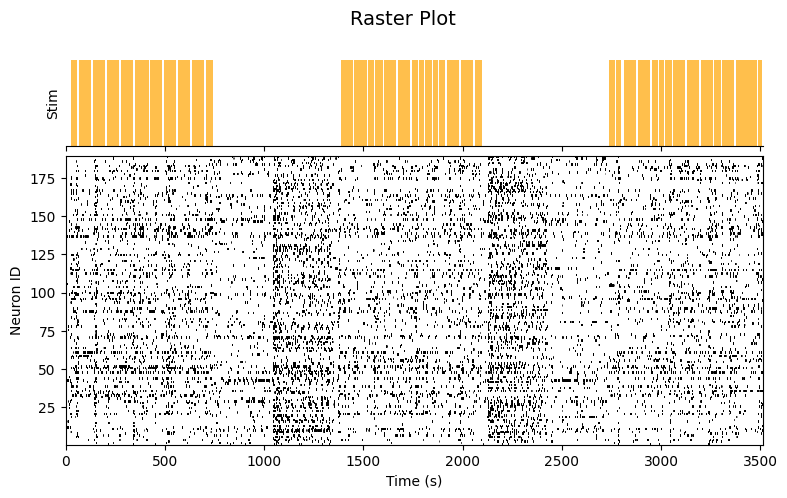

In [169]:
plot_raster_with_stimulus(
    oasis_spikes,
    stim_epochs,
    stim_metadata,
    stimulus_name="locally_sparse_noise",
    threshold=0.2,
    sampling_rate=fs,
    figsize=(9, 5),
    title="Raster Plot",
)

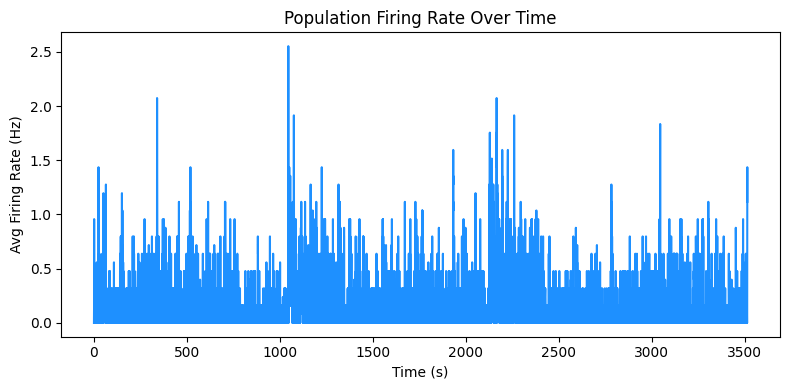

In [170]:
plot_population_firing_rate(
    oopsi_spikes, bin_size=2, sampling_rate=fs, threshold=0.2, figsize=(8, 4)
)

To adapt 

In [171]:
# Compare Neurons Spiking to White vs. Black Pixels

# # Choose a pixel to examine (e.g., center of stimulus)
# px, py = 8, 14  # (row, col)

# # Create a map from frame index → pixel value at (px, py)
# pixel_value_map = {i: stims[i][px, py] for i in range(len(stims))}

# # Add column to spikes dataframe
# oasis_with_frames["PixelValue"] = oasis_with_frames["StimFrameIdx"].map(pixel_value_map)

# # Filter by white or black
# white_spikes = oasis_with_frames[oasis_with_frames["PixelValue"] == 255]
# black_spikes = oasis_with_frames[oasis_with_frames["PixelValue"] == 0]

# # Count how many times each neuron spiked during white/black pixel at (px, py)
# white_counts = white_spikes["Neuron"].value_counts().sort_index()
# black_counts = black_spikes["Neuron"].value_counts().sort_index()

# # Combine and plot
# df_compare = pd.DataFrame({"White": white_counts, "Black": black_counts}).fillna(0)

# df_compare.plot(kind="bar", figsize=(12, 5))
# plt.title(f"Neuron Spike Counts for White vs Black Pixel at ({px}, {py})")
# plt.xlabel("Neuron ID")
# plt.ylabel("Spike Count")
# plt.tight_layout()
# plt.show()

In [172]:
from sklearn.preprocessing import minmax_scale


def normalize_spikes(spike_array):
    """
    Normalize spike traces to [0, 1] range neuron-wise.

    Args:
        spike_array: 2D numpy array (neurons x timepoints)

    Returns:
        Normalized 2D numpy array of same shape.
    """
    norm_spikes = np.zeros_like(spike_array, dtype=float)
    for i in range(spike_array.shape[0]):
        trace = spike_array[i]
        if np.max(trace) != np.min(trace):  # avoid division by zero
            norm_spikes[i] = minmax_scale(trace)
        else:
            norm_spikes[i] = trace  # all-zero trace stays zero
    return norm_spikes


# Create dataframes for more clear storage


def spikes_to_df(spikes_array, fs, threshold=0.2):
    """
    Convert normalized spike traces into DataFrame of spike events using threshold.

    Args:
        spikes_array: 2D numpy array (neurons × timepoints), normalized [0,1]
        fs: sampling frequency in Hz
        threshold: value above which a spike is counted

    Returns:
        pd.DataFrame with columns: Neuron, TimeIdx, Time (seconds)
    """
    spike_events = []
    n_neurons, n_timepoints = spikes_array.shape

    for neuron_id in range(n_neurons):
        spike_idxs = np.where(spikes_array[neuron_id] > threshold)[0]
        for idx in spike_idxs:
            spike_events.append({"Neuron": neuron_id, "TimeIdx": idx, "Time": idx / fs})

    return pd.DataFrame(spike_events)


def threshold_spikes_to_df(spikes_array, fs):
    """
    Convert binary threshold spikes array to DataFrame of spike events.

    Args:
        spikes_array: 2D numpy array (neurons x timepoints), binary 0/1
        fs: sampling frequency in Hz

    Returns:
        pd.DataFrame with columns: Neuron, TimeIdx, Time (seconds)
    """
    spike_events = []
    n_neurons, n_timepoints = spikes_array.shape
    for neuron_id in range(n_neurons):
        spike_idxs = np.where(spikes_array[neuron_id] == 1)[0]
        for idx in spike_idxs:
            spike_events.append({"Neuron": neuron_id, "TimeIdx": idx, "Time": idx / fs})
    return pd.DataFrame(spike_events)

In [173]:
# Normalize spikes for OOPSI and OASIS
oopsi_spikes_norm = normalize_spikes(oopsi_spikes)
oasis_spikes_norm = normalize_spikes(oasis_spikes)

# Threshold values for spike detection after normalization
oopsi_threshold = 0.2
oasis_threshold = 0.2

# Convert normalized spikes to DataFrames of events
oopsi_df = spikes_to_df(oopsi_spikes_norm, fs=fs, threshold=oopsi_threshold)
oasis_df = spikes_to_df(oasis_spikes_norm, fs=fs, threshold=oasis_threshold)

# Convert binary threshold spikes (already 0/1) to DataFrame
threshold_df = threshold_spikes_to_df(threshold_spikes, fs=fs)

# Count spikes per neuron for each method
spike_counts_threshold = threshold_df["Neuron"].value_counts().sort_index()
spike_counts_oopsi = oopsi_df["Neuron"].value_counts().sort_index()
spike_counts_oasis = oasis_df["Neuron"].value_counts().sort_index()

# Combine into one DataFrame, fill missing with zeros and cast to int
spike_counts_df = (
    pd.DataFrame(
        {
            "Threshold": spike_counts_threshold,
            "OOPSI": spike_counts_oopsi,
            "OASIS": spike_counts_oasis,
        }
    )
    .fillna(0)
    .astype(int)
)

print("\nSpike Counts Per Neuron:\n")
print(spike_counts_df)


Spike Counts Per Neuron:

     Threshold  OOPSI  OASIS
0           24    115    129
1           21    134    136
2           34    480    466
3           77    180    184
4           19    153    143
..         ...    ...    ...
184         31    105    106
185         48     83     92
186         39    298    318
187         46    737    718
188         43    348    388

[189 rows x 3 columns]


### 3. Correlation Analysis

In [174]:
correlations = spike_counts_df.corr()

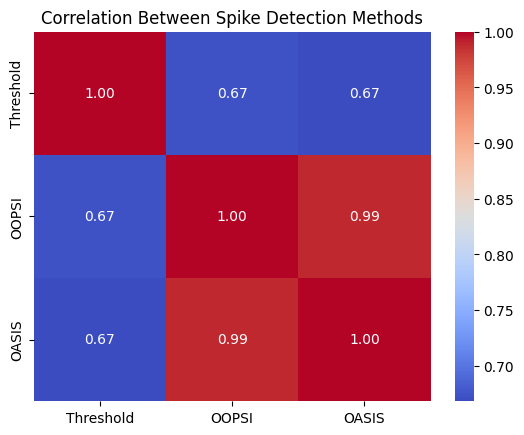

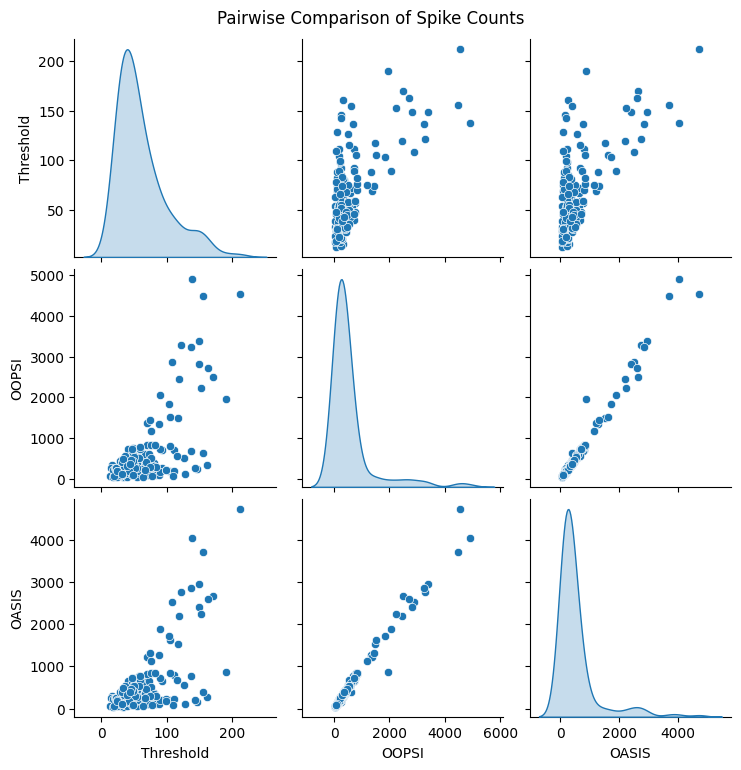

In [175]:
# Visualize correlations
import seaborn as sns

sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Spike Detection Methods")
plt.show()

sns.pairplot(spike_counts_df, diag_kind="kde")
plt.suptitle("Pairwise Comparison of Spike Counts", y=1.02)
plt.show()

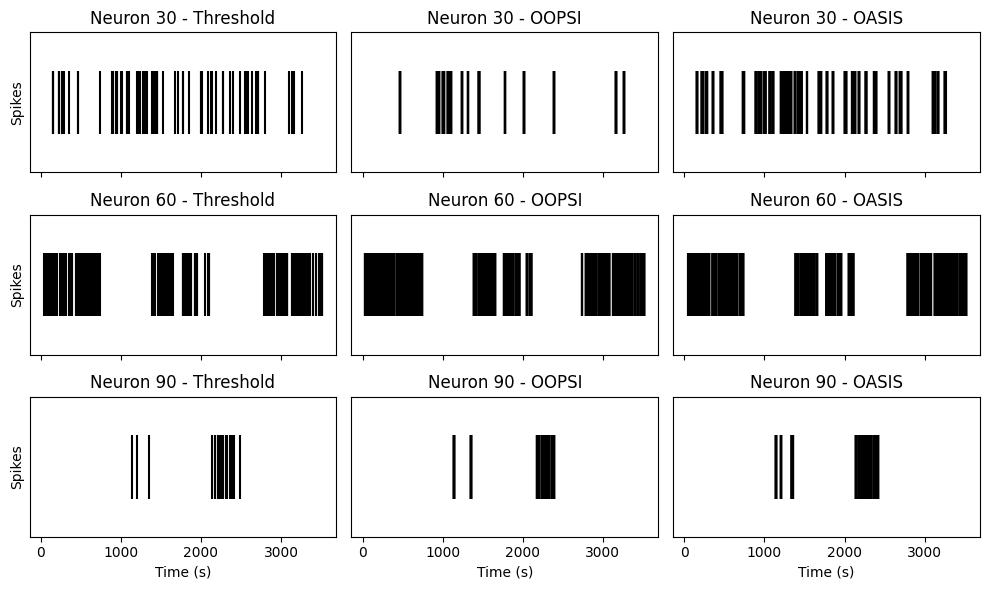

In [176]:
example_neurons = [30, 60, 90]
methods = ["Threshold", "OOPSI", "OASIS"]

# Create binary spike matrices for OOPSI and OASIS too:
# Assuming oopsi_spikes_norm and oasis_spikes_norm are your normalized spike matrices (neurons x timepoints)
oopsi_binary = (oopsi_spikes > oopsi_threshold).astype(int)
oasis_binary = (oasis_spikes > oopsi_threshold).astype(int)

spike_matrices = {
    "Threshold": threshold_spikes,
    "OOPSI": oopsi_binary,
    "OASIS": oasis_binary,
}

fig, axs = plt.subplots(
    len(example_neurons), len(methods), figsize=(10, 6), sharex=True, sharey=True
)

for i, neuron in enumerate(example_neurons):
    for j, method in enumerate(methods):
        spike_train = spike_matrices[method][neuron]
        spike_times = time[spike_train == 1]

        axs[i, j].eventplot(spike_times, lineoffsets=1, colors="black")
        axs[i, j].set_title(f"Neuron {neuron} - {method}")
        if i == len(example_neurons) - 1:
            axs[i, j].set_xlabel("Time (s)")
        if j == 0:
            axs[i, j].set_ylabel("Spikes")
        axs[i, j].set_yticks([])

plt.tight_layout()
plt.show()

In [177]:
def calculate_overlap_and_jitter(spike_train_a, spike_train_b, fs, window_ms=50):
    window_pts = int(window_ms / 1000 * fs)  # convert ms to samples

    spikes_a = np.where(spike_train_a)[0]
    spikes_b = np.where(spike_train_b)[0]

    matched_diffs = []
    matched_count = 0

    for spike in spikes_a:
        # Find spikes in B within window
        close_spikes = spikes_b[np.abs(spikes_b - spike) <= window_pts]
        if len(close_spikes) > 0:
            # Take closest spike time difference
            diff = np.min(np.abs(close_spikes - spike))
            matched_diffs.append(diff / fs)  # convert to seconds
            matched_count += 1

    overlap = matched_count / len(spikes_a) if len(spikes_a) > 0 else np.nan
    jitter = np.mean(matched_diffs) if matched_diffs else np.nan

    return overlap, jitter


overlap_results = []

for neuron_id in range(threshold_spikes.shape[0]):
    overlap_oo_th, jitter_oo_th = calculate_overlap_and_jitter(
        oopsi_binary[neuron_id], threshold_spikes[neuron_id], fs
    )
    overlap_oa_th, jitter_oa_th = calculate_overlap_and_jitter(
        oasis_binary[neuron_id], threshold_spikes[neuron_id], fs
    )
    overlap_oo_oa, jitter_oo_oa = calculate_overlap_and_jitter(
        oopsi_binary[neuron_id], oasis_binary[neuron_id], fs
    )
    overlap_results.append(
        {
            "Neuron": neuron_id,
            "OOPSI_vs_Threshold_overlap": overlap_oo_th,
            "OOPSI_vs_Threshold_jitter": jitter_oo_th,
            "OASIS_vs_Threshold_overlap": overlap_oa_th,
            "OASIS_vs_Threshold_jitter": jitter_oa_th,
            "OOPSI_vs_OASIS_overlap": overlap_oo_oa,
            "OOPSI_vs_OASIS_jitter": jitter_oo_oa,
        }
    )

overlap_df = pd.DataFrame(overlap_results)

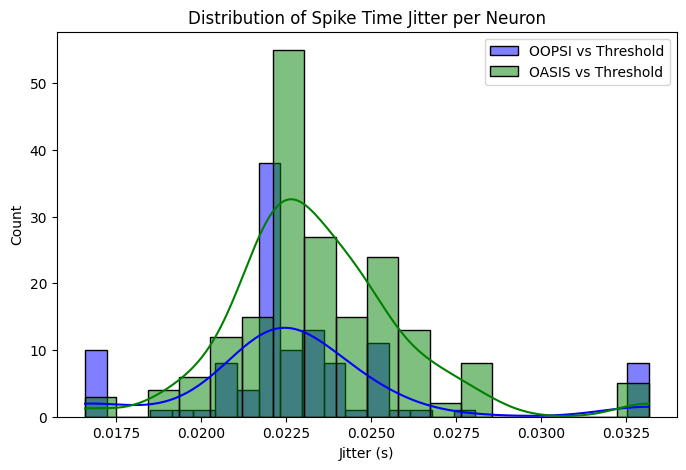

In [178]:
plt.figure(figsize=(8, 5))
sns.histplot(
    overlap_df["OOPSI_vs_Threshold_jitter"],
    label="OOPSI vs Threshold",
    color="blue",
    kde=True,
)
sns.histplot(
    overlap_df["OASIS_vs_Threshold_jitter"],
    label="OASIS vs Threshold",
    color="green",
    kde=True,
)
plt.xlabel("Jitter (s)")
plt.title("Distribution of Spike Time Jitter per Neuron")
plt.legend()
plt.show()

Correlation matrix reveals very high correlation (R = 0.99) between OASIS and OOPSI inferred spikes, with lower correlation values between OASIS and threshold and OOPSIE and threshold, both R = 0.67.

The Pairwise comparison plot also supports a very high correlation between OOPSI and OASIS and lower correlation with the thresholding method. 

We have also plotted the spike distributions for each method.

The rest of the analysis will be performed with OASIS spikes

# Receptive Fields Fitting

## 1. Spike-Triggered Average

In [179]:
def compute_sta_for_neuron(
    spike_trace, stims, stim_metadata, Dx, Dy, bin_size=2, n_lags=7
):
    """
    Compute spike-triggered average (STA) for a single neuron.

    Args:
        neuron_id (int): ID of neuron.
        spike_traces (ndarray): Shape (n_neurons, n_frames)
        stims (ndarray): Shape (n_unique_stims, Dx, Dy)
        stim_metadata (pd.DataFrame): Must contain 'frame', 'start', 'end'
        Dx, Dy (int): Stimulus dimensions
        bin_size (int): Number of frames per bin
        n_lags (int): Number of time bins to look back

    Returns:
        sta (np.ndarray): shape (n_lags, Dx, Dy)
    """
    n_frames = spike_trace.shape[0]
    stim_trace = np.full((n_frames, Dx, Dy), 0.0, dtype=np.float32)

    # Fill stimulus trace
    for i, row in stim_metadata.iterrows():
        stim_idx = row["frame"]
        start = row["start"]
        end = row["end"]
        stim_trace[start:end] = np.tile(stims[stim_idx], (end - start, 1, 1))

    # Bin spikes and stimuli

    n_bins = n_frames // bin_size
    n_trim = n_bins * bin_size

    spikes_binned = spike_trace[:n_trim].reshape(n_bins, bin_size).sum(axis=1)
    stim_binned = stim_trace[:n_trim].reshape(n_bins, bin_size, Dx, Dy).mean(axis=1)

    # Flatten stimuli
    pixels = Dx * Dy
    stim_flat = stim_binned.reshape(n_bins, pixels).T  # shape: (pixels, n_bins)

    # Compute STA
    sta = np.zeros((pixels, n_lags))
    valid_spike_count = 0

    for i in range(n_lags, n_bins):
        spike_val = spikes_binned[i]
        if spike_val > 0:
            sta += stim_flat[:, i - n_lags : i] * spike_val
            valid_spike_count += spike_val

    sta /= valid_spike_count + 1e-10  # avoid divide-by-zero
    return sta

In [180]:
def compute_sta_for_neuron_list(
    neuron_ids, oasis_spikes, stims, stim_metadata, bin_size=2, n_lags=7
):
    """
    Compute STAs for a list of neuron indices.

    Returns:
        stas (np.ndarray): shape (n_neurons, n_lags, Dx, Dy)
    """
    Dx, Dy = stims.shape[1:]
    stas = []

    for neuron_id in neuron_ids:
        spike_trace = oasis_spikes[neuron_id]
        sta = compute_sta_for_neuron(
            spike_trace,
            stims,
            stim_metadata,
            Dx,
            Dy,
            bin_size=bin_size,
            n_lags=n_lags,
        )
        stas.append(sta)

    return np.stack(stas, axis=0)  # shape: (n_neurons, n_lags, Dx, Dy)

In [181]:
def compute_spatial_temporal_kernel(sta, Dx, Dy, n_lags, bin_size):

    # --- SVD
    pixels = Dx * Dy
    sta_matrix = sta.reshape(pixels, n_lags)
    sta_centered = sta_matrix - sta_matrix.mean(axis=1, keepdims=True)

    U, S, VT = np.linalg.svd(sta_centered, full_matrices=False)
    spatial_kernel = U[:, 0].reshape(Dx, Dy)
    temporal_kernel = VT[0, :]
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(spatial_kernel, cmap="bwr")
    plt.colorbar()
    plt.title("Spatial Kernel")

    plt.subplot(1, 2, 2)
    time_axis = np.arange(-n_lags, 0) * bin_size * 1000 / 30  # ms
    plt.plot(time_axis, temporal_kernel)
    plt.xlabel("Time before spike (ms)")
    plt.title("Temporal Kernel")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

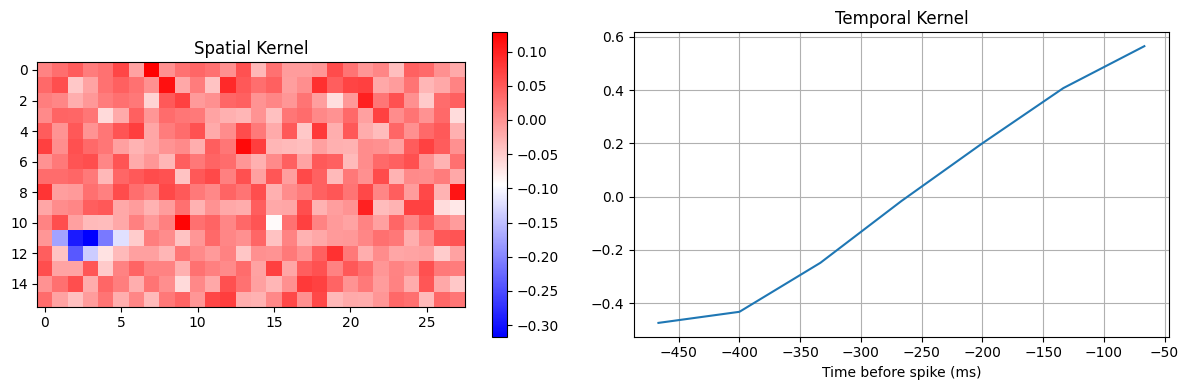

In [182]:
spike_trace = oasis_spikes[114]
bin_size = 2
Dx, Dy = stims.shape[1:]
n_lags = 7
sta = compute_sta_for_neuron(
    spike_trace, stims, stim_metadata, Dx, Dy, bin_size, n_lags
)
compute_spatial_temporal_kernel(sta, Dx, Dy, n_lags, bin_size)

In [183]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter


def plot_sta_grid(
    stas, neurons, Dx, Dy, cmap="bwr", title="STA Montage", vmin=None, vmax=None
):
    """
    Plots STAs for one or more neurons with a shared colorbar per row.

    Parameters:
    - stas: array of shape (n_neurons, Dx*Dy, n_lags) or (Dx*Dy, n_lags) for one neuron
    - neurons: list of neuron IDs (len = n_neurons), e.g., [43]
    - Dx, Dy: spatial stimulus dimensions
    - cmap: colormap
    - title: figure title
    - vmin, vmax: color scale bounds
    """
    # Handle single-neuron input
    if stas.ndim == 2:
        stas = stas[np.newaxis, ...]
    if isinstance(neurons, int):
        neurons = [neurons]

    n_neurons, _, n_lags = stas.shape
    fig, axes = plt.subplots(
        n_neurons, n_lags, figsize=(2.5 * n_lags, 2.5 * n_neurons), squeeze=False
    )

    for i in range(n_neurons):
        ims = []
        for j in range(n_lags):
            ax = axes[i, j]
            frame = stas[i, :, j].reshape(Dx, Dy)
            im = ax.imshow(
                gaussian_filter(frame, sigma=1),
                cmap=cmap,
                vmin=vmin,
                vmax=vmax,
            )
            ims.append(im)
            if i == 0:
                ax.set_title(f"Lag -{j}", fontsize=10)
            ax.axis("off")

        # Shared colorbar for the row
        cbar_ax = fig.add_axes(
            [0.91, 0.1 + (n_neurons - i - 1) / n_neurons * 0.8, 0.015, 0.8 / n_neurons]
        )
        fig.colorbar(ims[-1], cax=cbar_ax)

        axes[i, 0].set_ylabel(
            f"Neuron {neurons[i]}", fontsize=10, rotation=90, labelpad=10
        )

    fig.suptitle(title, fontsize=16)
    plt.subplots_adjust(
        left=0.05, right=0.9, top=0.93, bottom=0.05, wspace=0.1, hspace=0.2
    )
    plt.show()

In [184]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.ndimage import gaussian_filter


def plot_sta_grid(
    stas, neurons, Dx, Dy, cmap="bwr", title="STA Montage", vmin=None, vmax=None
):
    """
    Plot STA(s) with neuron IDs as y-axis labels and well-aligned colorbars.

    Parameters:
    - stas: (n_neurons, Dx*Dy, n_lags) or (Dx*Dy, n_lags)
    - neurons: list of neuron IDs or single neuron id
    - Dx, Dy: stimulus spatial dims
    - cmap: colormap
    - title: figure title
    - vmin, vmax: color scaling limits
    """
    # Normalize input shape & neuron IDs
    if stas.ndim == 2:
        stas = stas[np.newaxis, ...]
    if isinstance(neurons, int):
        neurons = [neurons]

    n_neurons, _, n_lags = stas.shape

    fig = plt.figure(figsize=(2.5 * n_lags + 1, 2.5 * n_neurons))
    gs = GridSpec(
        n_neurons,
        n_lags + 1,
        width_ratios=[1] * n_lags + [0.05],
        wspace=0.1,
        hspace=0.3,
    )

    for i in range(n_neurons):
        for j in range(n_lags):
            ax = fig.add_subplot(gs[i, j])
            frame = stas[i, :, j].reshape(Dx, Dy)
            im = ax.imshow(
                gaussian_filter(frame, sigma=1),
                cmap=cmap,
                vmin=vmin,
                vmax=vmax,
            )
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines[:].set_visible(False)
            if i == 0:
                ax.set_title(f"Lag -{j}", fontsize=10)

            # Add neuron ID label only on first column, centered vertically
            if j == 0:
                ax.set_ylabel(
                    f"Neuron {neurons[i]}",
                    fontsize=10,
                    rotation=90,
                    labelpad=15,
                    # va="center",
                )

        # Add colorbar for each neuron row in the last column
        cax = fig.add_subplot(gs[i, -1])
        plt.colorbar(im, cax=cax)
        cax.yaxis.set_ticks_position("right")
        cax.yaxis.set_label_position("right")

    fig.suptitle(title, fontsize=16)
    plt.show()

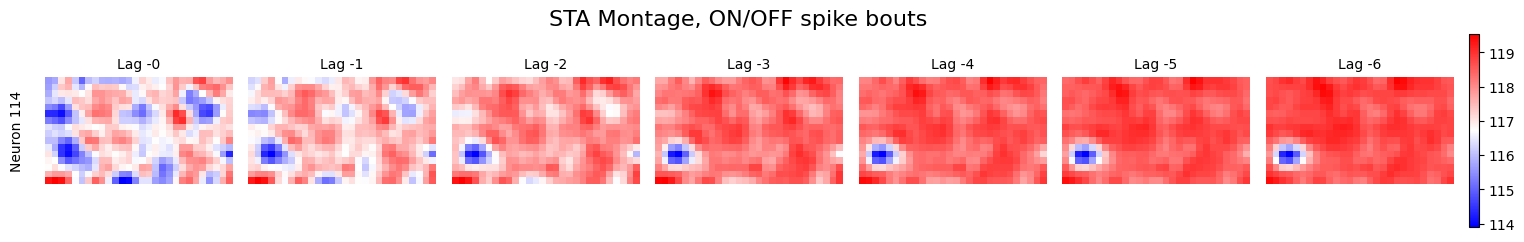

In [185]:
plot_sta_grid(
    sta,
    [114],
    Dx,
    Dy,
    cmap="bwr",
    title="STA Montage, ON/OFF spike bouts",
    vmin=None,
    vmax=None,
)

In [186]:
# Choose a spike detection threshold
spike_threshold = np.percentile(oasis_spikes, 99)

# Binary spike detection
binary_spikes = oasis_spikes > spike_threshold

# Count spikes per neuron
spike_counts = binary_spikes.sum(axis=1)

# Sort to find most active
top_5_active = np.argsort(spike_counts)[-5:]  # top 10 active neurons

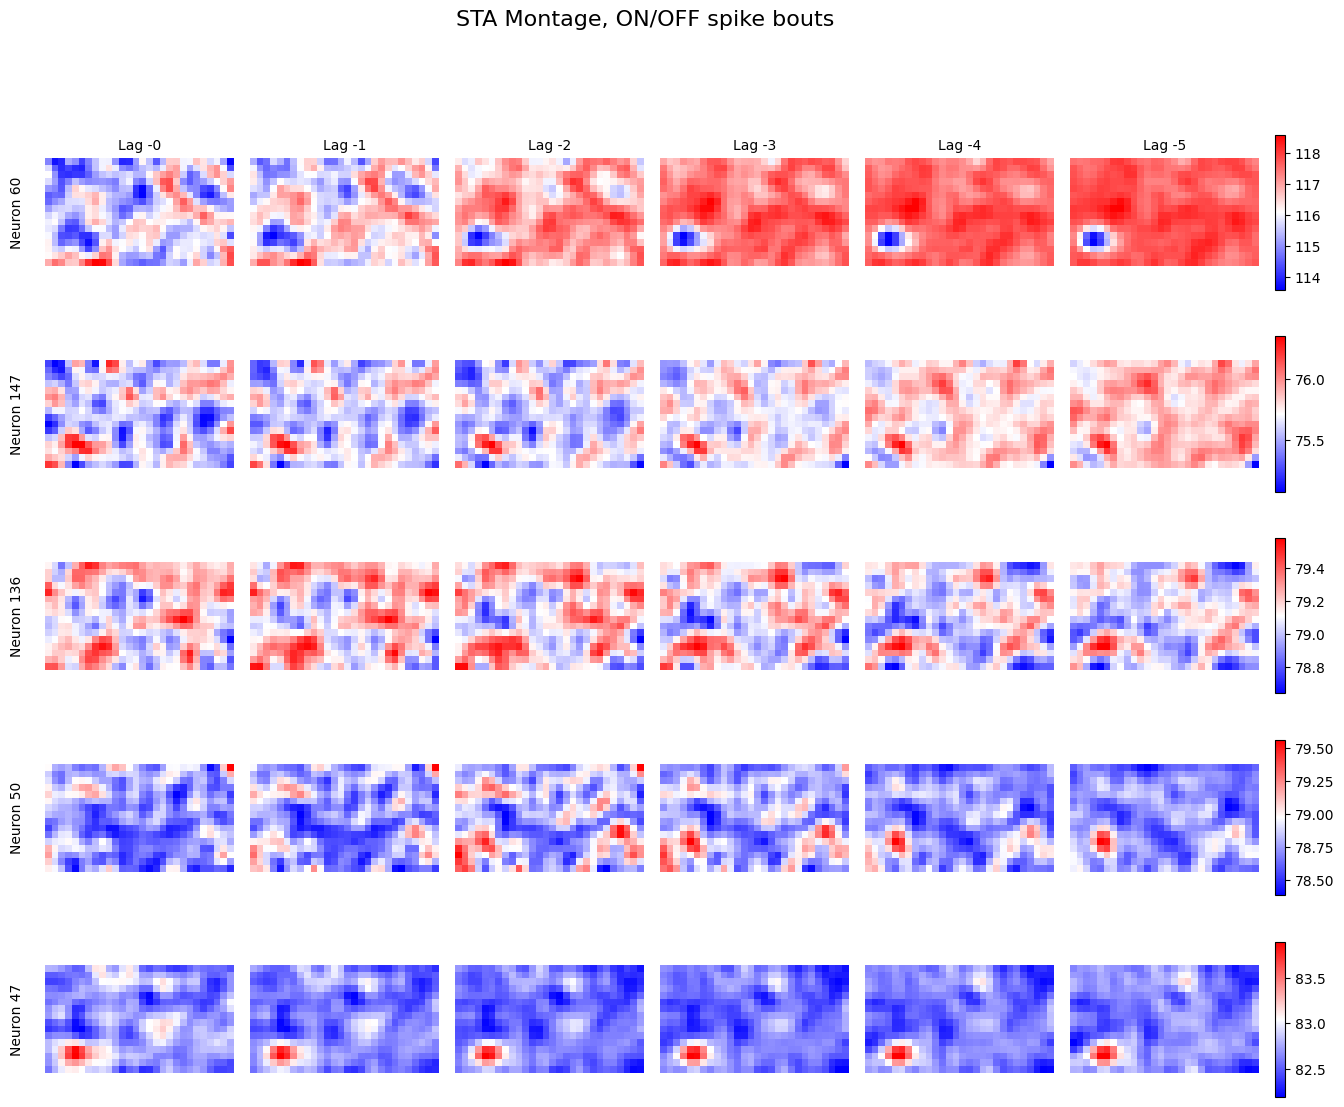

In [187]:
active_stas = compute_sta_for_neuron_list(
    top_5_active, oasis_spikes, stims, stim_metadata, bin_size=2, n_lags=6
)
plot_sta_grid(
    active_stas,
    top_5_active,
    Dx,
    Dy,
    cmap="bwr",
    title="STA Montage, ON/OFF spike bouts",
    vmin=None,
    vmax=None,
)

In [188]:
from scipy.ndimage import label


def count_active_bouts(spike_trace, threshold=0.2, min_gap=20):
    # Binary thresholded spike presence
    binary = spike_trace > threshold
    # Label connected regions (bouts of activity)
    labeled, n_bouts = label(binary)
    return n_bouts


# Apply to all neurons
bouts_per_neuron = np.array([count_active_bouts(trace) for trace in oasis_spikes])

# ON-OFF-like behavior: neurons with ~2 or more clear bouts
on_off_like_indices = np.where((bouts_per_neuron >= 90))[0]
on_off_like_indices = on_off_like_indices[5:10]

In [189]:
onoff_stas = compute_sta_for_neuron_list(
    on_off_like_indices, oasis_spikes, stims, stim_metadata, bin_size=2, n_lags=7
)

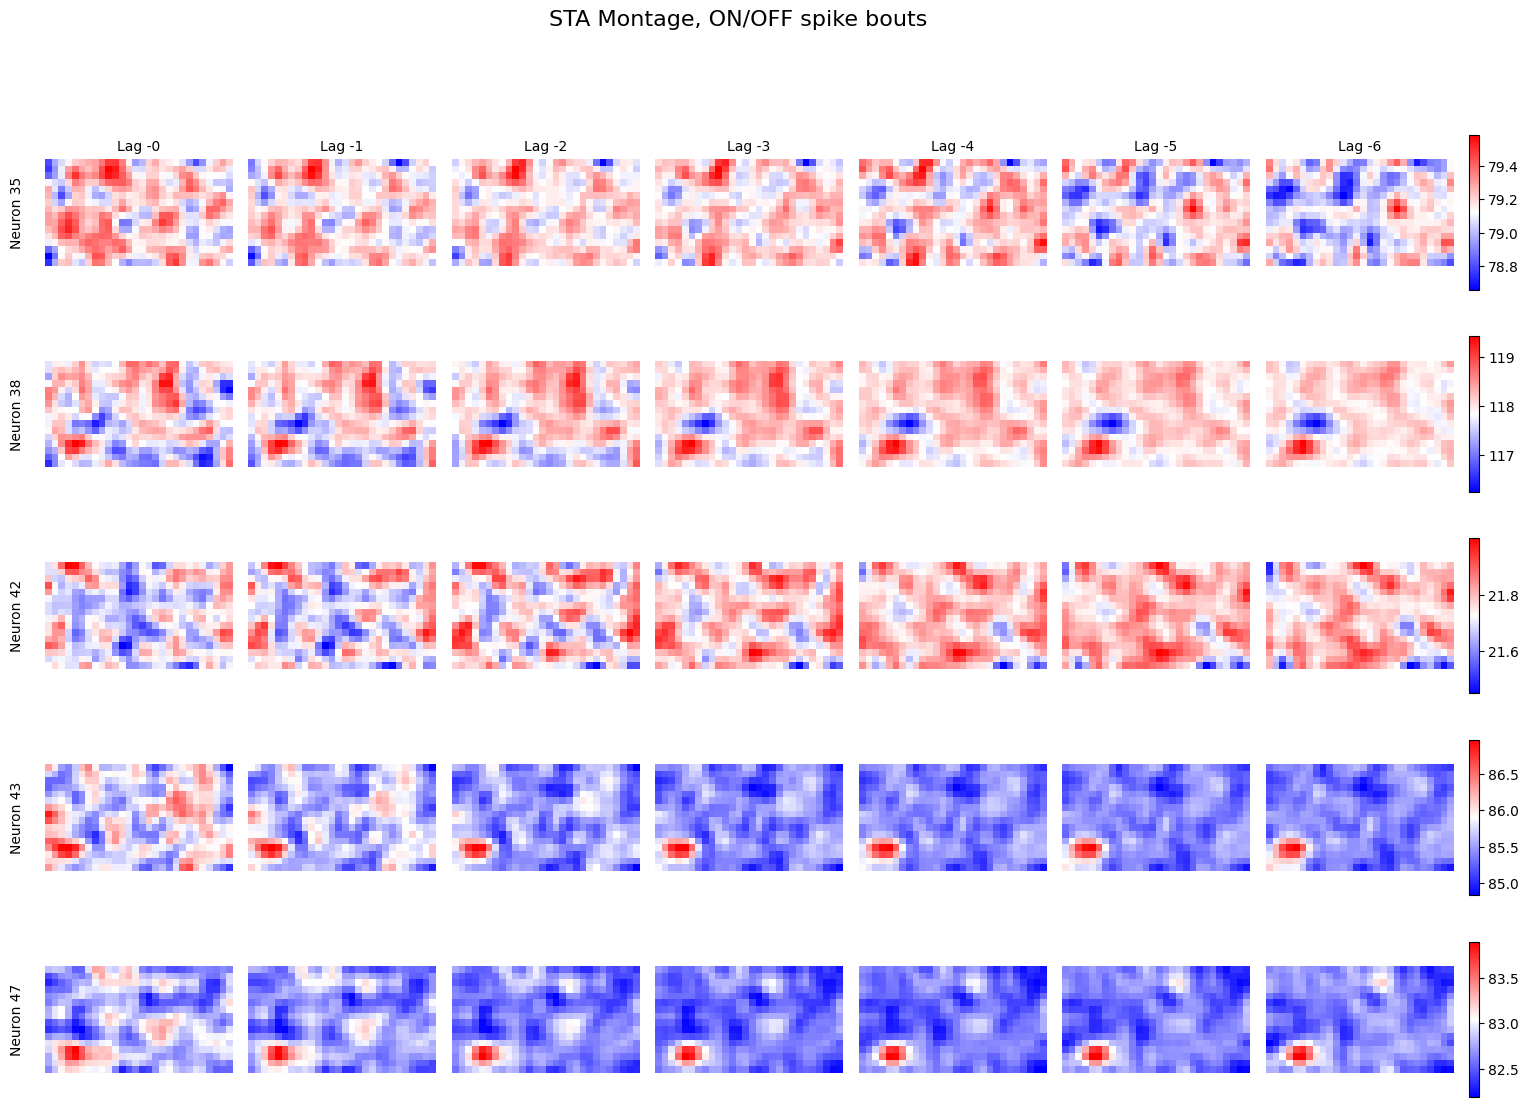

In [190]:
plot_sta_grid(
    onoff_stas,
    on_off_like_indices,
    Dx,
    Dy,
    cmap="bwr",
    title="STA Montage, ON/OFF spike bouts",
    vmin=None,
    vmax=None,
)

## 2. LNP

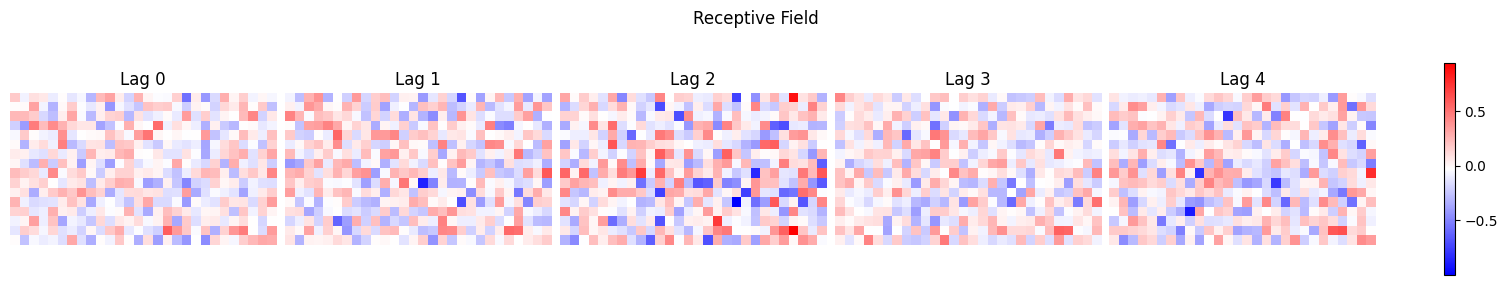

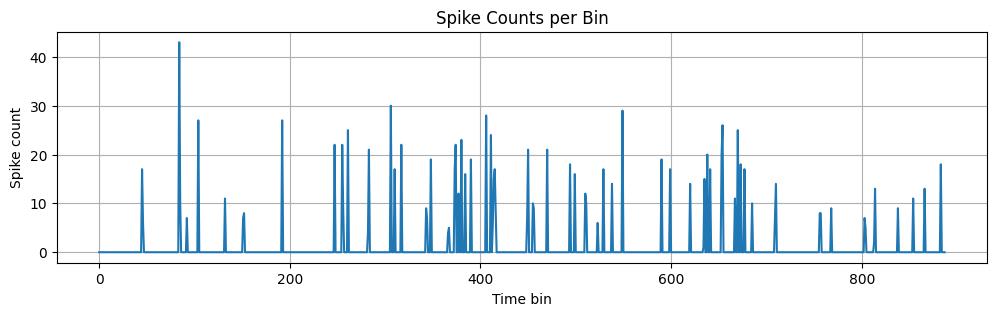

Min spike count: 0
Max spike count: 43
Mean spike count: 1.2725225225225225
Fraction zero bins: 0.9144144144144144


In [191]:
from scipy.optimize import minimize
from functools import partial
from scipy.special import gammaln


neuron_id = 10
spike_threshold = 0.2
bin_size = 10  # 2 frames = ~66.7 ms @ 30 Hz
lags = [0, 1, 2, 3, 4]
R = 50


# ----------------------------------
# Compute discrete spike counts
# ----------------------------------
def compute_spike_counts_from_trace(
    spike_trace, stim_metadata, valid_frame_indices, spike_threshold
):
    spike_counts = []
    for idx in valid_frame_indices:
        start = stim_metadata.iloc[idx]["start"]
        end = stim_metadata.iloc[idx]["end"]
        binary_spikes = spike_trace[start:end] > spike_threshold
        spike_count = binary_spikes.sum()
        spike_counts.append(spike_count)
    return np.array(spike_counts)


def bin_spike_counts(spike_counts, bin_size):
    n_bins = len(spike_counts) // bin_size
    trimmed = spike_counts[: n_bins * bin_size]
    return trimmed.reshape(n_bins, bin_size).sum(axis=1)


# ----------------------------------
# Get valid stimulus frame indices
# ----------------------------------
lsn_epochs = stim_epochs[stim_epochs["stimulus"] == "locally_sparse_noise"]
valid_indices = []
for _, row in lsn_epochs.iterrows():
    valid = stim_metadata[
        (stim_metadata["start"] >= row["start"]) & (stim_metadata["end"] <= row["end"])
    ]
    valid_indices.extend(valid.index.tolist())

# ----------------------------------
# Compute spike counts and bin them
# ----------------------------------
framewise_spike_counts = compute_spike_counts_from_trace(
    oasis_spikes[neuron_id, :], stim_metadata, valid_indices, spike_threshold
)
binned_spike_counts = bin_spike_counts(framewise_spike_counts, bin_size)


# ----------------------------------
# Bin stimulus frames to match spike bins
# ----------------------------------
def bin_stimulus_frames(stim_metadata, stims, valid_indices, bin_size):
    Dx, Dy = stims.shape[1:]
    valid_frames = stim_metadata.iloc[valid_indices]["frame"].values
    n_bins = len(valid_frames) // bin_size
    stim_binned = []

    for i in range(n_bins):
        chunk = valid_frames[i * bin_size : (i + 1) * bin_size]
        stim_images = np.stack([stims[f] for f in chunk])
        stim_binned.append(np.mean(stim_images, axis=0))

    return np.stack(stim_binned)


stim_binned = bin_stimulus_frames(stim_metadata, stims, valid_indices, bin_size)

# ----------------------------------
# Align lengths (just in case)
# ----------------------------------
min_len = min(len(binned_spike_counts), stim_binned.shape[0])
binned_spike_counts = binned_spike_counts[:min_len]
stim_binned = stim_binned[:min_len]

# ----------------------------------
# Normalize stimuli
# ----------------------------------
stim_mean = stim_binned.mean()
stim_std = stim_binned.std()
stim_binned = (stim_binned - stim_mean) / stim_std
# stim_binned = zscore(stim_binned, axis=None)


# ----------------------------------
# LNP Model Fitting
# ----------------------------------
def fit_receptive_field_lnp(spike_counts, stims, lags, dt, R=50):
    Dx, Dy = stims.shape[1:]
    n_frames = stims.shape[0]
    stim_reshaped = stims.reshape(n_frames, Dx * Dy).T
    w_hat = np.zeros((Dx * Dy, len(lags)))

    for i, lag in enumerate(lags):
        if lag > 0:
            s_lag = stim_reshaped[:, :-lag]
            c_lag = spike_counts[lag:]
        else:
            s_lag = stim_reshaped
            c_lag = spike_counts

        def negloglike(w, dt, R):
            lin_drive = np.clip(w.T @ s_lag, -20, 20)
            r = np.exp(lin_drive) * dt * R
            r = np.maximum(r, 1e-12)
            val = -np.sum(c_lag * np.log(r) - r - gammaln(c_lag + 1))
            if not np.isfinite(val):
                print("Non-finite negloglike:", val)
            return val

        def dnegloglike(w, dt, R):
            lin_drive = np.clip(w.T @ s_lag, -20, 20)
            r = np.exp(lin_drive) * dt * R
            r = np.maximum(r, 1e-12)
            grad = s_lag @ (r - c_lag)
            if not np.all(np.isfinite(grad)):
                print("Non-finite gradient detected.")
            return grad

        w0 = np.random.randn(Dx * Dy) * 0.1
        res = minimize(
            partial(negloglike, dt=dt, R=R),
            w0,
            jac=partial(dnegloglike, dt=dt, R=R),
            method="L-BFGS-B",
            options={"maxiter": 1000, "gtol": 1e-5},
        )
        if not res.success:
            print(f"Optimization failed at lag {lag}: {res.message}")
        w_hat[:, i] = res.x

    return w_hat.reshape(Dx, Dy, len(lags))


# Fit
rf = fit_receptive_field_lnp(binned_spike_counts, stim_binned, lags, dt, R=R)


# ----------------------------------
# Plotting
# ----------------------------------
def plot_rf(rf, cmap="bwr", title="Receptive Field", vmin=None, vmax=None):
    n_lags = rf.shape[-1]
    fig, axs = plt.subplots(1, n_lags, figsize=(n_lags * 3, 3), constrained_layout=True)
    if n_lags == 1:
        axs = [axs]  # Make axs always iterable

    vmin = vmin if vmin is not None else np.min(rf)
    vmax = vmax if vmax is not None else np.max(rf)

    for i in range(n_lags):
        axs[i].imshow(rf[:, :, i], cmap=cmap, vmin=vmin, vmax=vmax)
        axs[i].set_title(f"Lag {i}")
        axs[i].axis("off")

    fig.colorbar(axs[0].images[0], ax=axs, orientation="vertical", shrink=0.8)
    fig.suptitle(title)
    plt.show()


plot_rf(rf)
# ----------------------------------
# Diagnostics: spike count trace
# ----------------------------------
plt.figure(figsize=(12, 3))
plt.plot(binned_spike_counts)
plt.title("Spike Counts per Bin")
plt.xlabel("Time bin")
plt.ylabel("Spike count")
plt.grid(True)
plt.show()

print("Min spike count:", np.min(binned_spike_counts))
print("Max spike count:", np.max(binned_spike_counts))
print("Mean spike count:", np.mean(binned_spike_counts))
print("Fraction zero bins:", np.mean(binned_spike_counts == 0))

### 2.1 LNP with Lasso Regularization

 Fitting Lasso with alpha=0.001
 Fitting Lasso with alpha=0.01
 Fitting Lasso with alpha=0.1
 Plotting RF for alpha=0.001


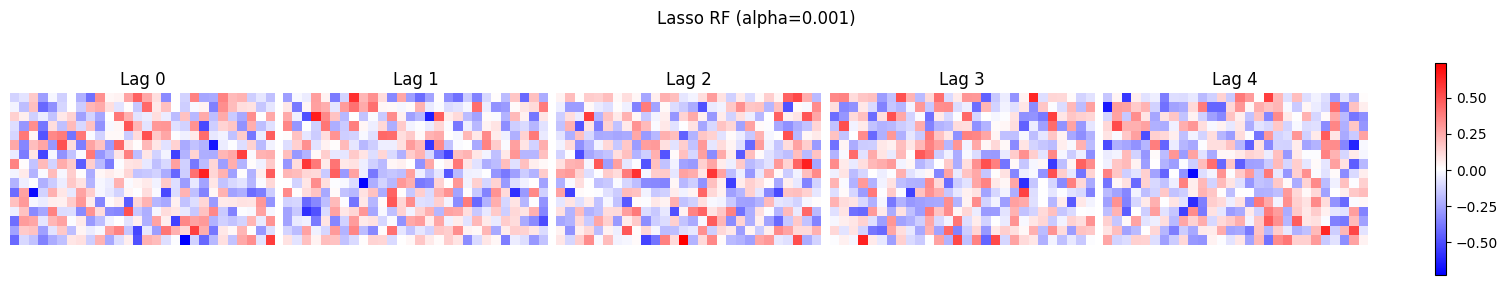

 Plotting RF for alpha=0.01


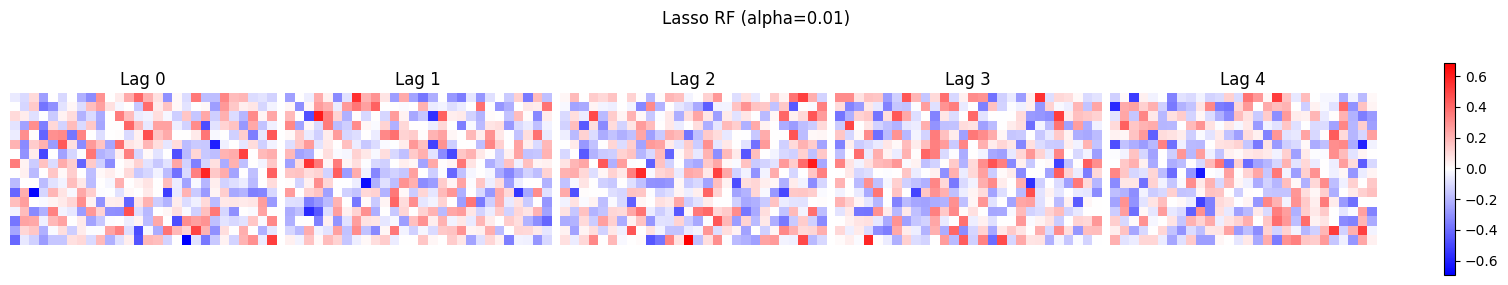

 Plotting RF for alpha=0.1


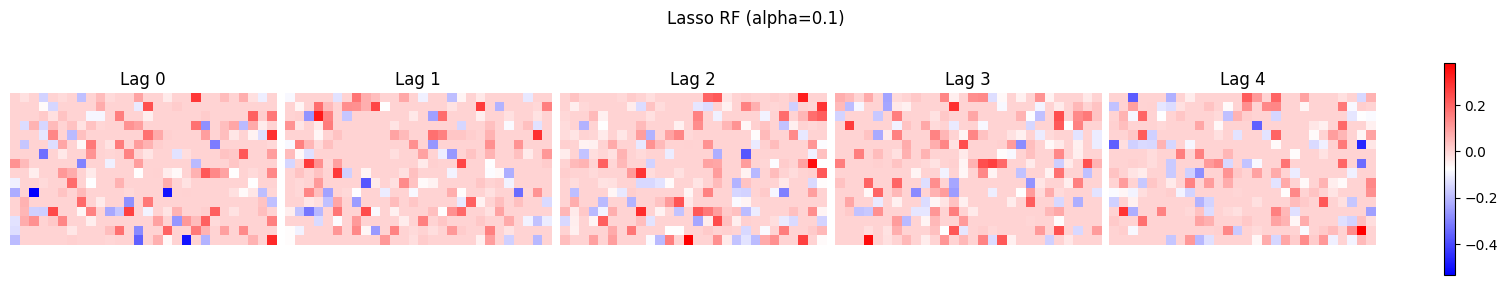

Max coefficient: 0.5333006143423924


In [ ]:
from sklearn.linear_model import Lasso


# ----------------------------------
# Lasso Fitting Function
# ----------------------------------
def fit_receptive_field_lasso(spike_counts, stims, lags, alpha=0.01, max_iter=10000):
    Dx, Dy = stims.shape[1:3]
    n_frames = stims.shape[0]
    n_lags = len(lags)

    stim_reshaped = stims.reshape(n_frames, Dx * Dy).T  # (pixels, time)
    w_hat = np.zeros((Dx * Dy, n_lags))

    for i, lag in enumerate(lags):
        if lag > 0:
            s_lag = stim_reshaped[:, :-lag].T  # (time-lag, pixels)
            c_lag = spike_counts[lag:]  # (time-lag,)
        else:
            s_lag = stim_reshaped.T  # (time, pixels)
            c_lag = spike_counts  # (time,)

        model = Lasso(alpha=alpha, max_iter=max_iter, random_state=42)
        model.fit(s_lag, c_lag)
        w_hat[:, i] = model.coef_

    return w_hat.reshape(Dx, Dy, n_lags)


# ----------------------------------
# Lasso Sweep
# ----------------------------------
alphas = [0.001, 0.01, 0.1]
rf_lasso_dict = {}

for alpha in alphas:
    print(f" Fitting Lasso with alpha={alpha}")
    rf_lasso = fit_receptive_field_lasso(
        binned_spike_counts, stim_binned, lags, alpha=alpha
    )
    rf_lasso_dict[alpha] = rf_lasso


# ----------------------------------
# Plotting Function
# ----------------------------------
def plot_rf(rf, cmap="bwr", title="Receptive Field", vmin=None, vmax=None):
    n_lags = rf.shape[-1]
    fig, axs = plt.subplots(1, n_lags, figsize=(n_lags * 3, 3), constrained_layout=True)
    if n_lags == 1:
        axs = [axs]

    vmin = vmin if vmin is not None else np.min(rf)
    vmax = vmax if vmax is not None else np.max(rf)

    for i in range(n_lags):
        axs[i].imshow(gaussian_filter(
            rf[:, :, i],1),
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
        )
        axs[i].set_title(f"Lag {i}")
        axs[i].axis("off")

    fig.colorbar(axs[0].images[0], ax=axs, orientation="vertical", shrink=0.8)
    fig.suptitle(title)
    plt.show()


# ----------------------------------
# Visualize Results
# ----------------------------------
for alpha in alphas:
    print(f" Plotting RF for alpha={alpha}")
    plot_rf(rf_lasso_dict[alpha], title=f"Lasso RF (alpha={alpha})")

rf = rf_lasso_dict[0.1]
print("Max coefficient:", np.max(np.abs(rf)))

### 2.2 LNP (initialization with STA)

C:\Users\34600\AppData\Local\Temp\ipykernel_2068\155793666.py:62: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  res = minimize(


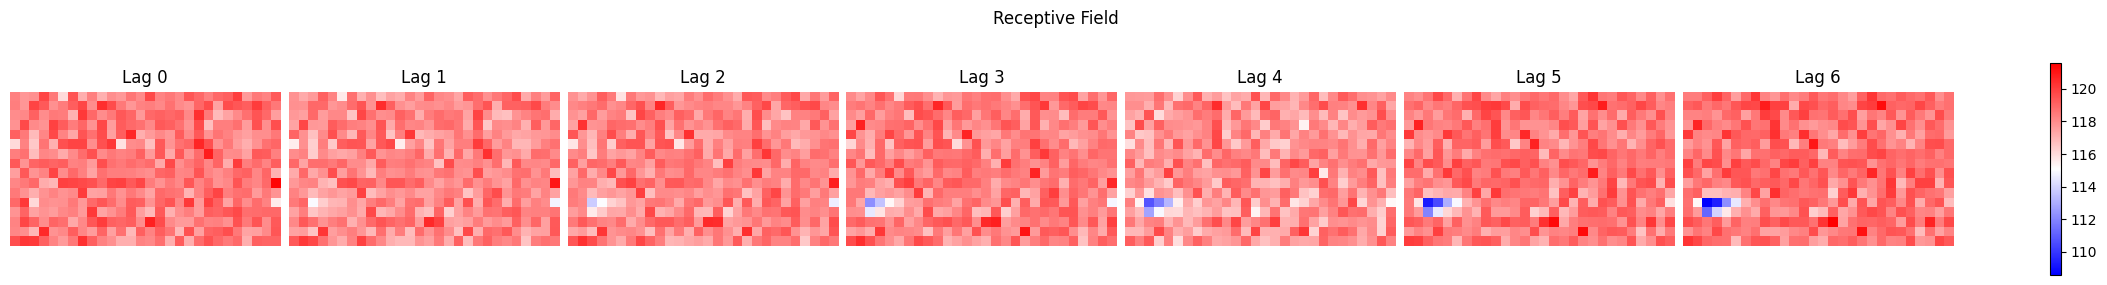

In [193]:
lags = [0, 1, 2, 3, 4, 5, 6]
bin_size = 10  # 2 frames = ~66.7 ms @ 30 Hz


def fit_receptive_field_lnp_with_sta_init(spike_counts, stims, lags, dt, sta, R=50):
    """
    Fit LNP receptive field using Poisson loss, with STA initialization.

    Args:
        spike_counts (np.ndarray): Binned spike counts, shape (n_timebins,)
        stims (np.ndarray): Binned and normalized stimuli, shape (n_timebins, Dx, Dy)
        lags (list of int): Temporal lags to include (e.g., [0, 1, 2, 3, 4])
        dt (float): Bin duration in seconds
        sta (np.ndarray): Spike-triggered average, shape (n_lags, Dx, Dy)
        R (float): Scaling factor for rate (optional)

    Returns:
        rf (np.ndarray): Receptive field, shape (Dx, Dy, len(lags))
    """
    Dx, Dy = stims.shape[1:]
    n_frames = stims.shape[0]

    # Flatten stimulus: shape (Dx*Dy, n_frames)
    stim_reshaped = stims.reshape(n_frames, Dx * Dy).T  # shape (pixels, time)

    if sta.shape == (Dx * Dy, len(lags)):
        sta_for_init = sta
    elif sta.shape == (len(lags), Dx, Dy):
        sta_for_init = sta.transpose(1, 2, 0).reshape(Dx * Dy, len(lags))
    else:
        raise ValueError(
            f"STA shape {sta.shape} does not match expected ({Dx*Dy}, {len(lags)}) or ({len(lags)}, {Dx}, {Dy})"
        )

    # Output weight matrix
    w_hat = np.zeros((Dx * Dy, len(lags)))

    for i, lag in enumerate(lags):
        if lag > 0:
            s_lag = stim_reshaped[:, :-lag]
            c_lag = spike_counts[lag:]
        else:
            s_lag = stim_reshaped
            c_lag = spike_counts

        # Poisson negative log-likelihood
        def negloglike(w, dt, R):
            lin_drive = np.clip(w.T @ s_lag, -20, 20)
            r = np.exp(lin_drive) * dt * R
            r = np.maximum(r, 1e-12)
            return -np.sum(c_lag * np.log(r) - r - gammaln(c_lag + 1))

        def dnegloglike(w, dt, R):
            lin_drive = np.clip(w.T @ s_lag, -20, 20)
            r = np.exp(lin_drive) * dt * R
            r = np.maximum(r, 1e-12)
            return s_lag @ (r - c_lag)

        # STA-based initialization
        w0 = sta_for_init[:, i].copy()

        res = minimize(
            partial(negloglike, dt=dt, R=R),
            w0,
            jac=partial(dnegloglike, dt=dt, R=R),
            method="TNC",
            options={"maxiter": 1000, "gtol": 1e-5},
        )

        if not res.success:
            print(f"Optimization failed at lag {lag}: {res.message}")

        w_hat[:, i] = res.x

    # Reshape to (Dx, Dy, n_lags)
    return w_hat.reshape(Dx, Dy, len(lags))


# sta_reshaped = sta.T.reshape(len(lags), Dx, Dy)  # shape (lags, Dx, Dy)

rf = fit_receptive_field_lnp_with_sta_init(
    binned_spike_counts, stim_binned, lags, dt=(bin_size / 30), sta=sta, R=50
)


plot_rf(rf)

GLM fitting? no f idea

C:\Users\34600\AppData\Local\Temp\ipykernel_2068\773740054.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


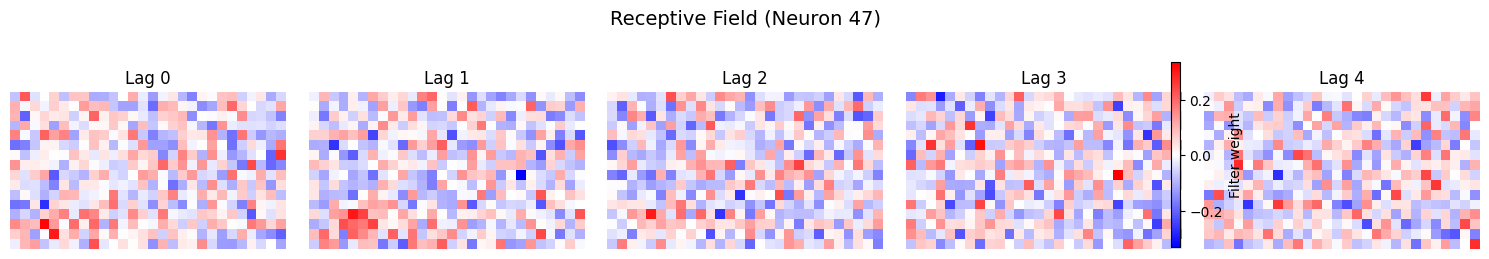

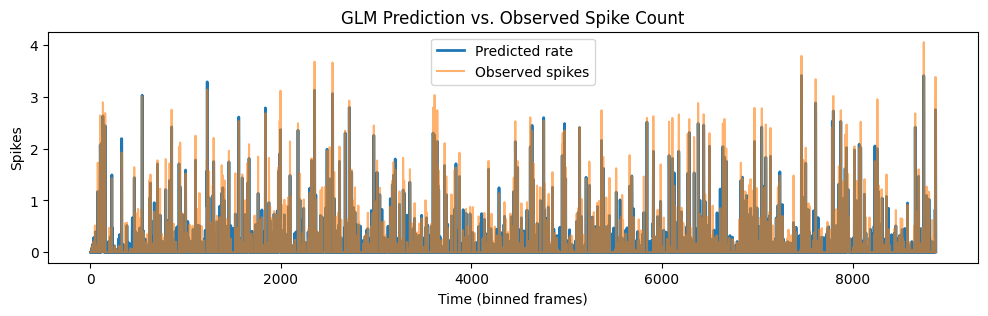

In [208]:
# not binary - GLM
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import StandardScaler

neuron_id = 47
n_lags = 5  # temporal depth of filter
bin_size = 2  # keep per-frame resolution
frame_rate = fs


# ------------------------------------------------------------
# Step 2: Build design matrix with temporal lags
# ------------------------------------------------------------
Dx, Dy = stims.shape[1:]
n_frames = len(lsn_frame_idxs)
stim_stack = np.stack([stims[f] for f in lsn_frame_idxs])  # (n, Dx, Dy)
stim_flat = stim_stack.reshape(n_frames, -1)  # (n, Dx*Dy)


def build_lagged_design_matrix(X, n_lags):
    n_time, n_feat = X.shape
    X_lagged = np.zeros((n_time - n_lags + 1, n_feat * n_lags))
    for t in range(n_lags, n_time + 1):
        lagged_window = X[t - n_lags : t][::-1].reshape(-1)
        X_lagged[t - n_lags] = lagged_window
    return X_lagged


X_lagged = build_lagged_design_matrix(stim_flat, n_lags)  # (n-lags+1, Dx*Dy*n_lags)


# ------------------------------------------------------------
# Step 3: Get spike counts aligned with stimulus bins
# ------------------------------------------------------------
def get_spike_counts_per_frame(spike_trace, stim_metadata, valid_idx):
    counts = []
    for i in valid_idx:
        start = stim_metadata.iloc[i]["start"]
        end = stim_metadata.iloc[i]["end"]
        count = spike_trace[start:end].sum()
        counts.append(count)
    return np.array(counts)


valid_idx = stim_metadata[stim_metadata["frame"].isin(lsn_frame_idxs)].index
spike_counts = get_spike_counts_per_frame(
    oasis_spikes[neuron_id, :], stim_metadata, valid_idx
)
spike_counts = spike_counts[n_lags - 1 :]  # align with lagged design matrix

# ------------------------------------------------------------
# Step 4: Fit GLM (Poisson regression)
# ------------------------------------------------------------
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_lagged)

glm = PoissonRegressor(alpha=0.0, max_iter=1000)
glm.fit(X_scaled, spike_counts)

# ------------------------------------------------------------
# Step 5: Visualize filters with interpolation
# ------------------------------------------------------------
filters = glm.coef_.reshape(n_lags, Dx, Dy)

fig, axs = plt.subplots(1, n_lags, figsize=(3 * n_lags, 3))
axs = np.atleast_1d(axs)  # Ensure axs is iterable even if n_lags == 1

vmin, vmax = filters.min(), filters.max()

for i in range(n_lags):
    im = axs[i].imshow(
        filters[i],
        cmap="bwr",
        vmin=vmin,
        vmax=vmax,
    )
    axs[i].set_title(f"Lag {i}")
    axs[i].axis("off")

# Add one colorbar for all subplots
fig.colorbar(im, ax=axs, orientation="vertical", shrink=0.8, label="Filter weight")

fig.suptitle(f"Receptive Field (Neuron {neuron_id})", fontsize=14)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Step 6: Plot prediction vs actual
# ------------------------------------------------------------
pred_rate = glm.predict(X_scaled)
plt.figure(figsize=(12, 3))
plt.plot(pred_rate, label="Predicted rate", lw=2)
plt.plot(spike_counts, label="Observed spikes", alpha=0.6)
plt.legend()
plt.title("GLM Prediction vs. Observed Spike Count")
plt.xlabel("Time (binned frames)")
plt.ylabel("Spikes")
plt.show()

## RF with Berens Library

In [196]:
Dx, Dy = stims.shape[1:]
dims = [Dx, Dy]
df = [int(np.maximum(np.ceil(dim / 2), 3)) for dim in list(dims)]

In [197]:
def build_stimulus_matrix(stims, stim_epochs, stim_metadata, trace_length):
    """
    Builds stimulus matrix `s` of shape (Dx * Dy, nT), where each column is the stimulus
    shown at that timepoint, or zeros if no stimulus was shown.

    Parameters:
        stims: np.array of shape (9000, Dx, Dy)
        stim_epochs: pd.DataFrame with 'stimulus', 'start', 'end'
        stim_metadata: pd.DataFrame with 'frame', 'start', 'end'
        trace_length: int, number of timepoints in spike train

    Returns:
        s: np.array of shape (Dx*Dy, nT)
    """

    Dx, Dy = stims.shape[1], stims.shape[2]
    nT = trace_length
    s = np.zeros((nT, Dx, Dy), dtype=stims.dtype)

    # Filter epochs for locally sparse noise
    lsn_epochs = stim_epochs[stim_epochs["stimulus"] == "locally_sparse_noise"]

    # Flatten each stim frame once
    flat_stims = stims.reshape(stims.shape[0], -1)  # shape (9000, Dx*Dy)

    # Loop through all metadata rows and check if the frame belongs to LSN
    for _, row in stim_metadata.iterrows():
        frame = row["frame"]
        t_start = int(row["start"])
        t_end = int(row["end"])

        # Check if this frame falls within any LSN epoch
        in_lsn = any(
            (t_start >= epoch_start) and (t_end <= epoch_end)
            for epoch_start, epoch_end in zip(lsn_epochs["start"], lsn_epochs["end"])
        )
        if in_lsn and frame < len(flat_stims):
            # Fill in the same stimulus vector across the time window
            s[t_start:t_end, :] = stims[frame]
            # [:, np.newaxis]
    s = s.reshape(nT, Dx, Dy)
    return s

In [198]:
trace_length = len(oasis_spikes[0, :])
stims_valid = build_stimulus_matrix(stims, stim_epochs, stim_metadata, trace_length)

In [199]:
n_stim = stims_valid.shape[0]
X = build_design_matrix(stims_valid.reshape((n_stim, -1)), 1)
# Neurons to analyze
neuron_indices = [38, 60]  # Add more indices here if needed

# Container to store filters for each neuron and method
filters = {idx: {} for idx in neuron_indices}

# ALD init params
sigma0 = [1.0]
rho0 = [1.0]
params_t0 = [3.0, 20.0, 1.0, 1.0]
params_y0 = [3.0, 20.0, 1.0, 1.0]
p0 = sigma0 + rho0 + params_t0 + params_y0

### STA, MLE, ASD & ALD

In [200]:
# Loop through neurons
for idx in neuron_indices:
    print(f"Processing neuron {idx}")
    y = oasis_spikes[idx, :]

    # 1. STA
    w_sta = X.T @ y
    filters[idx]["STA"] = w_sta

    # 2. MLE
    w_mle = np.linalg.inv(X.T @ X) @ X.T @ y
    filters[idx]["MLE"] = w_mle

    # 3. ASD
    asd = ASD(X, y, dims=dims)
    asd.fit(
        p0=[1.0, 1.0, 6.0, 6.0],
        num_iters=30,
        verbose=10,
    )
    w_asd = asd.optimized_C_post @ X.T @ y / asd.optimized_params[0] ** 2
    filters[idx]["ASD"] = w_asd

    # 4. ALD
    ald = ALD(X, y, dims=dims)
    ald.fit(p0=p0, num_iters=30, verbose=10)
    w_ald = ald.optimized_C_post @ X.T @ y / ald.optimized_params[0] ** 2
    filters[idx]["ALD"] = w_ald

Processing neuron 38
Iter	σ	ρ	δt	δs	cost
   0	0.990	0.990	6.010	6.010	96244.223
  10	0.890	0.950	6.107	6.087	84932.199
  20	0.787	0.914	6.201	6.155	72015.278
Stop: reached 30 steps, final cost=58392.37745.
* Due to space limit, parameters for frequency domain are not printed.
Iter	σ	ρ	τ_t	ν_t	τ_y	ν_y	cost
   0	0.990	0.990	2.990	20.010	2.990	20.010	93401.437
  10	0.890	0.937	3.036	19.962	3.009	19.999	81932.756
  20	0.787	0.946	3.064	19.933	3.035	19.983	68956.000
Stop: reached 30 steps, final cost=55284.53266.
Processing neuron 60
Iter	σ	ρ	δt	δs	cost
   0	0.990	0.990	6.010	6.010	96363.688
  10	0.890	0.907	6.076	6.099	85073.060
  20	0.787	0.864	6.076	6.151	72207.323
Stop: reached 30 steps, final cost=58662.09019.
* Due to space limit, parameters for frequency domain are not printed.
Iter	σ	ρ	τ_t	ν_t	τ_y	ν_y	cost
   0	0.990	0.990	2.990	20.010	2.990	20.010	93520.902
  10	0.890	0.991	2.995	20.002	3.053	19.950	82068.860
  20	0.787	1.029	2.984	20.012	3.076	19.936	69031.486
Stop: reached 30 ste

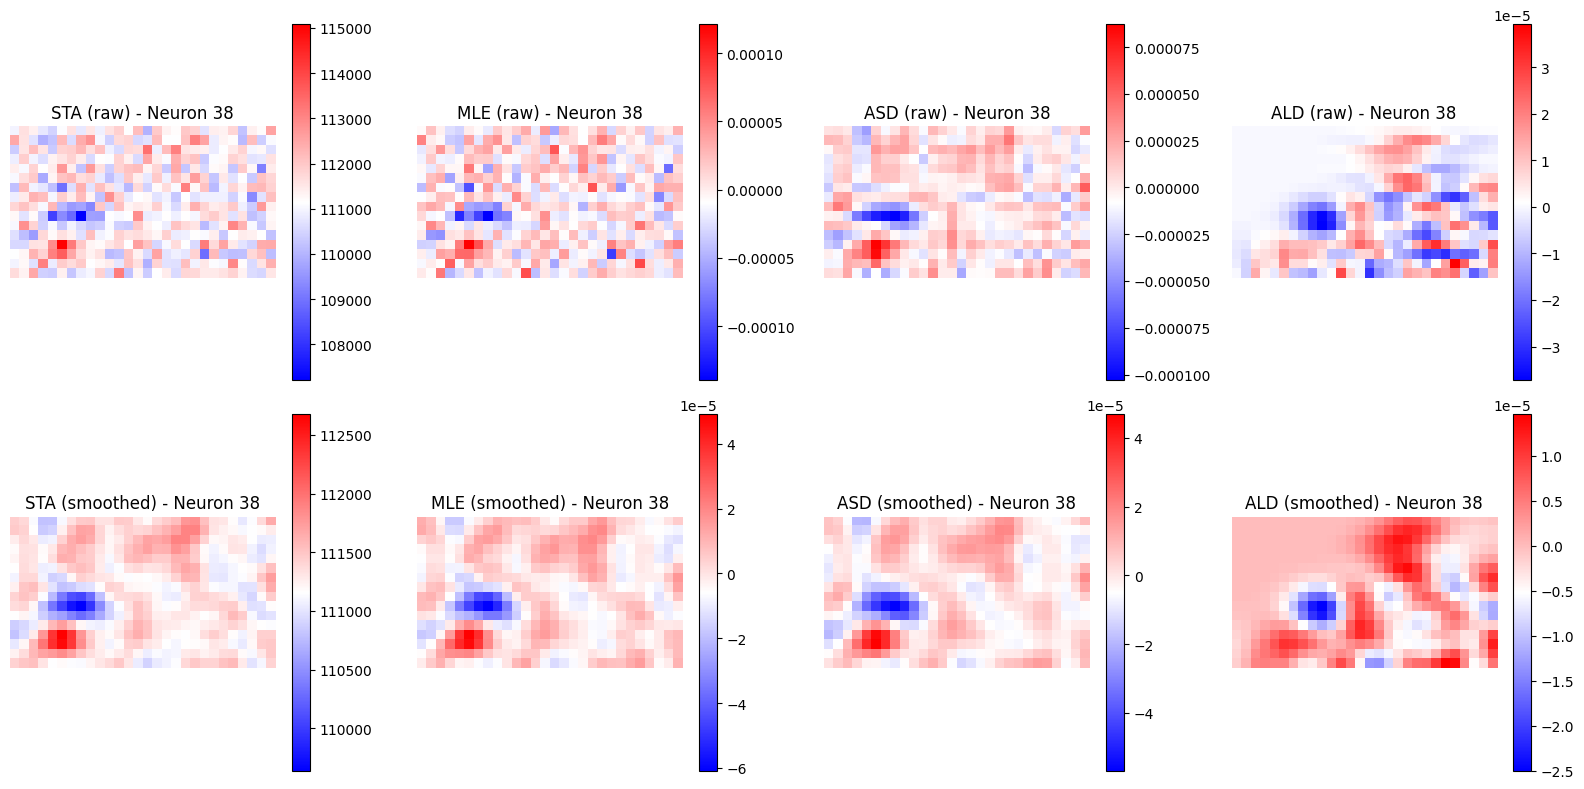

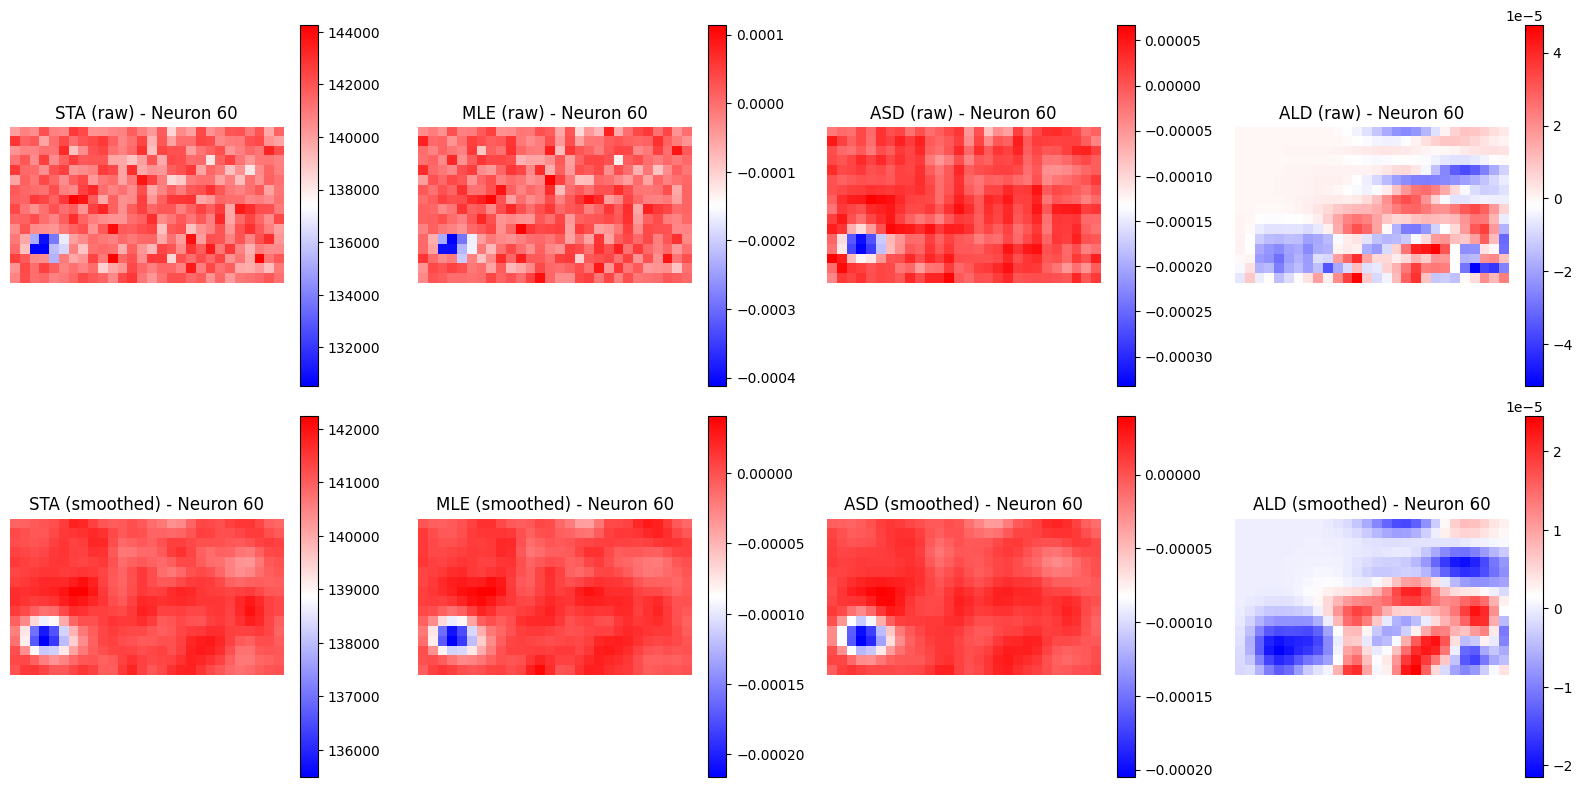

In [201]:
for idx in neuron_indices:
    plt.figure(figsize=(16, 8))
    methods = ["STA", "MLE", "ASD", "ALD"]
    for i, method in enumerate(methods):
        w = filters[idx][method].reshape(Dx, Dy)

        # Raw
        plt.subplot(2, len(methods), i + 1)
        plt.imshow(w, cmap="bwr")
        plt.title(f"{method} (raw) - Neuron {idx}")
        plt.axis("off")
        plt.colorbar()

        # Smoothed
        plt.subplot(2, len(methods), i + 1 + len(methods))
        plt.imshow(gaussian_filter(w, sigma=1), cmap="bwr")
        plt.title(f"{method} (smoothed) - Neuron {idx}")
        plt.axis("off")
        plt.colorbar()

    plt.tight_layout()
    plt.show()

### LNP & LNLN (don't work)

In [222]:
import pickle
import os

# Load existing filters if they exist
if os.path.exists("filters.pkl"):
    with open("filters.pkl", "rb") as f:
        filters = pickle.load(f)
else:
    filters = {}

# Loop over neurons
for neuron_id in [60]:  # replace with any list of neuron indices
    print(f"Processing neuron {neuron_id}")
    y = oasis_spikes[neuron_id, :]

    # 5. LNP
    lnp = LNP(X, y, dims, dt=dt)
    lnp.fit(verbose=10, fit_nonlinearity=True)

    if neuron_id not in filters:
        filters[neuron_id] = {}

    filters[neuron_id]["LNP_opt"] = lnp.w_opt
    filters[neuron_id]["LNP_sta"] = lnp.w_sta

    # 6. LNLN
    lnln = LNLN(X, y, dims, dt=dt)
    lnln.fit(verbose=10, fit_nonlinearity=True)

    filters[neuron_id]["LNLN_w_opt"] = lnln.w_opt
    filters[neuron_id]["LNLN_w_sta"] = lnln.w_sta

# Save updated filters back to disk
with open("filters.pkl", "wb") as f:
    pickle.dump(filters, f)

print("Saved filters for all processed neurons.")

Processing neuron 60
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            8.174        48439.994       
Stop: reached 5 steps.

Returning model: best_train_cost at iteration 4 of 4 (Max: 5).

Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            7.046        3391.408        
10           7.880        3234.642        
20           8.704        3125.144        
30           9.512        3037.034        
40           10.316       2965.990        
50           11.130       2909.809        
60           11.931       2866.464        
70           12.730       2833.857        
80           13.556       2809.920        
90           14.393       2792.754        
100          15.239       2780.715        
110          16.180       2772.448        
120          17.002       2766.880        
130          17.814       2763.195        
140          18.645       2760.786        
150          19.466       2759.221        
160       

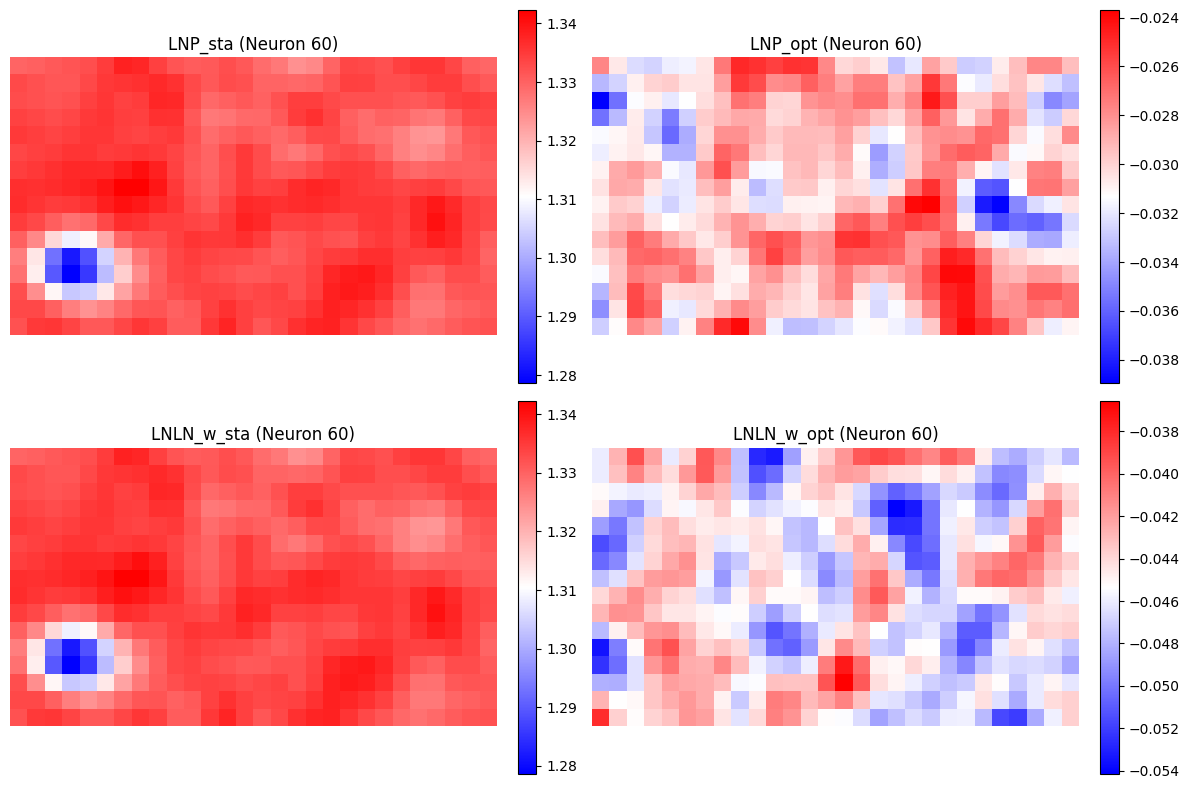

In [230]:
neuron_id = 60
filter_dict = filters[neuron_id]

Dx, Dy = dims[0], dims[1]  # assuming dims = [time, x, y] or similar order

keys = [
    "LNP_sta",
    "LNP_opt",
    "LNLN_w_sta",
    "LNLN_w_opt",
]

plt.figure(figsize=(12, 8))

for i, key in enumerate(keys):
    w = filter_dict.get(key)
    if w is None:
        print(f"Warning: {key} missing for neuron {neuron_id}")
        continue

    # Handle cases where filter has multiple components (e.g., shape (448, 2))
    if w.ndim == 2:
        if w.shape[0] == Dx * Dy and w.shape[1] == 2:
            # shape (448, 2) → pick first filter
            w = w[:, 0]
        elif w.shape[1] == Dx * Dy and w.shape[0] == 2:
            # shape (2, 448) → pick first filter
            w = w[0, :]

    # Reshape to spatial dims
    try:
        w = w.reshape(Dx, Dy)
    except Exception as e:
        print(f"Could not reshape filter {key} for neuron {neuron_id}: {e}")
        continue

    plt.subplot(2, 2, i + 1)
    plt.imshow(gaussian_filter(w, sigma=1), cmap="bwr")
    plt.title(f"{key} (Neuron {neuron_id})")
    plt.axis("off")
    plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

### splineLNP & splineLNLN

In [220]:
neuron_id = 60
# 7. splineLNP
spl_lnp = splineLNP(X, y, dims=dims, dt=dt, df=df)
spl_lnp.fit(verbose=10, fit_nonlinearity=True)

if neuron_id not in filters:
    filters[neuron_id] = {}

filters[neuron_id]["splineLNP_w_opt"] = spl_lnp.w_opt  # Store filter(s)

# 8. splineLNLN
spl_lnln = splineLNLN(X, y, dims=dims, dt=dt, df=df)
spl_lnln.fit(verbose=10, fit_nonlinearity=True)

filters[neuron_id]["splineLNLN_w_opt"] = spl_lnln.w_opt

# Then save filters dictionary to disk if you want:
import pickle

with open("filters.pkl", "wb") as f:
    pickle.dump(filters, f)

Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            2.653        30503.747       
10           3.057        7955.914        
20           3.398        2897.420        
30           3.780        4234.588        
40           4.127        3246.456        
50           4.508        3019.621        
60           4.903        2913.882        
70           5.311        2872.862        
80           5.656        2834.005        
90           6.024        2828.551        
100          6.403        2822.866        
110          6.821        2817.409        
120          7.192        2813.198        
130          7.565        2808.950        
140          7.914        2805.175        
150          8.271        2801.609        
160          8.616        2798.263        
170          8.967        2795.109        
180          9.322        2792.114        
190          9.703        2789.251        
200          10.101       2786.501        
210          10.523   

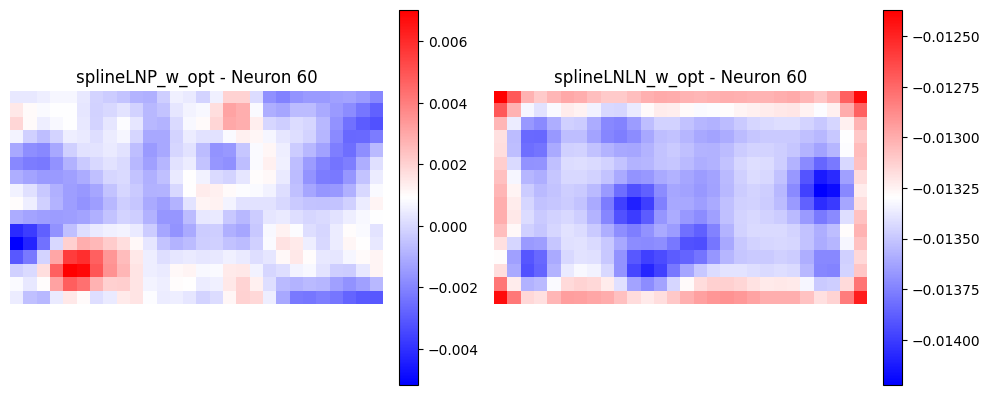

In [221]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

neuron_id = 60  # or whichever neuron you want to plot
filter_dict = filters[neuron_id]

keys = [
    "splineLNP_w_opt",
    "splineLNLN_w_opt",
]

plt.figure(figsize=(10, 5))

for i, key in enumerate(keys):
    w = filter_dict.get(key)
    if w is None:
        print(f"Warning: {key} missing for neuron {neuron_id}")
        continue

    # If filter has multiple components, pick first (adjust if needed)
    if w.ndim == 2 and w.shape[0] < w.shape[1]:
        w = w[0]
    elif w.ndim == 2 and w.shape[1] < w.shape[0]:
        w = w[:, 0]

    try:
        w_reshaped = w.reshape(Dx, Dy)
    except Exception as e:
        print(f"Could not reshape {key} for neuron {neuron_id}: {e}")
        continue

    plt.subplot(1, 2, i + 1)
    plt.imshow(gaussian_filter(w_reshaped, sigma=1), cmap="bwr")
    plt.title(f"{key} - Neuron {neuron_id}")
    plt.axis("off")
    plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

## Do RF have spatial correlation? 

In [ ]:
from scipy.ndimage import center_of_mass

rf = w_sta
# Example: for one receptive field map `rf` (2D numpy array)
rf_center = center_of_mass(np.abs(rf))  # or use rf directly if you want signed info

In [ ]:
cortical_pos_38 = center_of_mass(roi_masks[38])  # (y, x)

In [ ]:
n_neurons = roi_masks.shape[0]
neuron_ids = np.arange(n_neurons)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass
from tqdm import tqdm

# Settings
dt = 0.3  # stimulus duration in seconds
df = [12, 24]  # you can adjust this if needed
Dx, Dy = stims_valid.shape[1:]
dims = [Dx, Dy]

n_neurons = oasis_spikes.shape[0]
rf_results = []

# Loop over all neuron IDs
for neuron_id in tqdm(neuron_ids):
    try:
        # 1. Build design matrix
        X = build_design_matrix(stims_valid.reshape((stims_valid.shape[0], -1)), 1)
        y = oasis_spikes[neuron_id]

        # 2. Fit LNP model
        model = LNP(X, y, dims=dims, dt=dt, compute_mle=True)
        model.fit(verbose=0, fit_nonlinearity=True)

        # 3. Get RF map (w_sta)
        w_sta = model.__dict__["w_sta"].reshape(Dx, Dy)

        # 4. Compute RF center (in visual space)
        rf_center = center_of_mass(np.abs(w_sta))  # (y, x)

        # 5. Compute cortical position from ROI mask
        roi_mask = roi_masks[neuron_id]
        cortical_pos = center_of_mass(roi_mask)  # (y, x)

        # 6. Store result
        rf_results.append(
            {
                "neuron_id": neuron_id,
                "rf_map": w_sta,
                "rf_center": rf_center,
                "cortical_position": cortical_pos,
            }
        )

    except Exception as e:
        print(f"Error for neuron {neuron_id}: {e}")
        continue

100%|██████████| 189/189 [18:05<00:00,  5.75s/it]


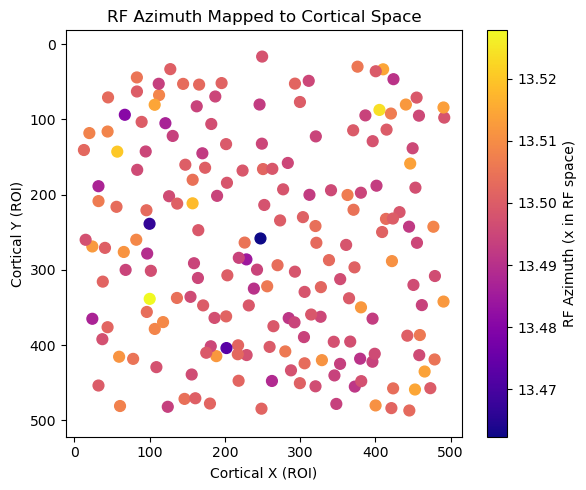

In [ ]:
# Extract data
positions = np.array([d["cortical_position"] for d in rf_results])
rf_centers = np.array([d["rf_center"] for d in rf_results])

# Color by RF azimuth (x-position in visual space)
rf_azimuth = rf_centers[:, 1]

plt.figure(figsize=(6, 5))
plt.scatter(positions[:, 1], positions[:, 0], c=rf_azimuth, cmap="plasma", s=60)
plt.colorbar(label="RF Azimuth (x in RF space)")
plt.xlabel("Cortical X (ROI)")
plt.ylabel("Cortical Y (ROI)")
plt.title("RF Azimuth Mapped to Cortical Space")
plt.gca().invert_yaxis()
plt.axis("equal")
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import spearmanr

# Get cortical x and y positions
cort_x = positions[:, 1]
cort_y = positions[:, 0]

# RF azimuth
azimuth = rf_centers[:, 1]

# Correlation of azimuth with cortical axes
corr_x, _ = spearmanr(cort_x, azimuth)
corr_y, _ = spearmanr(cort_y, azimuth)

print(f"Spearman correlation with cortical X: {corr_x:.2f}")
print(f"Spearman correlation with cortical Y: {corr_y:.2f}")

Spearman correlation with cortical X: -0.03
Spearman correlation with cortical Y: 0.00
